# Evaluate prediction for ICI response, Figure3

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from scipy import stats
import sys,os
from collections import defaultdict, Counter
from matplotlib import patches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint

In [3]:
print(sys.version)

3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:33:30) 
[Clang 9.0.1 ]


In [4]:
%pip list | grep -e "numpy" -e "pandas" -e "matplotlib" -e "scipy" -e "seaborn"  -e "statsmodels" -e "sklearn"

matplotlib            3.3.2
matplotlib-inline     0.1.3
numpy                 1.19.5
pandas                1.2.3
scipy                 1.7.3
seaborn               0.11.2
statsmodels           0.13.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=4,3
plt.rcParams['figure.dpi']=300
plt.rcParams['axes.linewidth'] =0.5
plt.rcParams['lines.linewidth'] =0.5
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# set font size
SMALL_SIZE = 7
MEDIUM_SIZE = 8
LARGE_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=LARGE_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('axes', linewidth=0.5) 
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

In [6]:
store="../results/"

In [7]:
cluster_order=["SMK","UVL","APB","MRD","POL","HRD","GNS","AGE"]
cluster_order2=["SMK","UVL","APB","MRD","POL","HRD","GNS","AGE","UND"]
cluster_colors=["red","blue","green","purple","brown","hotpink","c","y"]
cluster_colors2=["red","blue","green","purple","brown","hotpink","c","y","grey"]

In [8]:
# import data
df0=pd.read_csv("/Users/tshiro/Desktop/Projects/pancancer_TMB_MSI_IRS/paper_preparation1/jupyter_notes/ICI_response_cohort_975_curated_20211210.tsv"
                ,sep="\t",index_col=0)

In [9]:
np.nanmedian(df0["Age"])

62.0

In [10]:
ageh=[]
for idx in df0.index:
    if  df0.loc[idx,"Age"]>=62:
        ageh.append(1)
    elif df0.loc[idx,"Age"]<62:
        ageh.append(0)
    else:
        ageh.append(np.nan)
df0["Age_high"]=ageh

# Single Double therapy

In [11]:
single_therapy=[]
for idx in df0.index:
    if df0.loc[idx,"Treatment"] in ["CTLA4+PD1/PDL1","CTLA4+PD1","CTLA4->PD1"]:
        single_therapy.append(0)
    else:
        single_therapy.append(1)
df0["ICI_single"]=single_therapy

# TMB cut-off from FM-ONE

In [12]:
# import Passing Bablok regression results in R
pb_para=pd.read_csv("../analysis_in_R/Passing_Bablok_results.tsv"
                    ,sep="\t",index_col=0)
pb_para

,EST,SE,LCI,UCI
Intercept,1.814174,NaN,0.973855,2.791982
Slope,0.047230,NaN,0.040266,0.052601


In [13]:
cutoff1=( 10-pb_para.loc["Intercept","EST"]) /pb_para.loc["Slope","EST"]
cutoff1

173.3166492146599

In [14]:
# check CI
cutoff1_l=( 10-pb_para.loc["Intercept","LCI"]) /pb_para.loc["Slope","LCI"]
cutoff1_u=( 10-pb_para.loc["Intercept","UCI"]) /pb_para.loc["Slope","UCI"]
print(cutoff1_l,cutoff1_u)

224.1649670514298 137.03253770579335


In [15]:
blca2018=pd.read_csv("../analysis_in_R/Nature2018_BLCA_FM1_WES.tsv",sep="\t",index_col=0)

r= 0.820, P= 2.91e-54


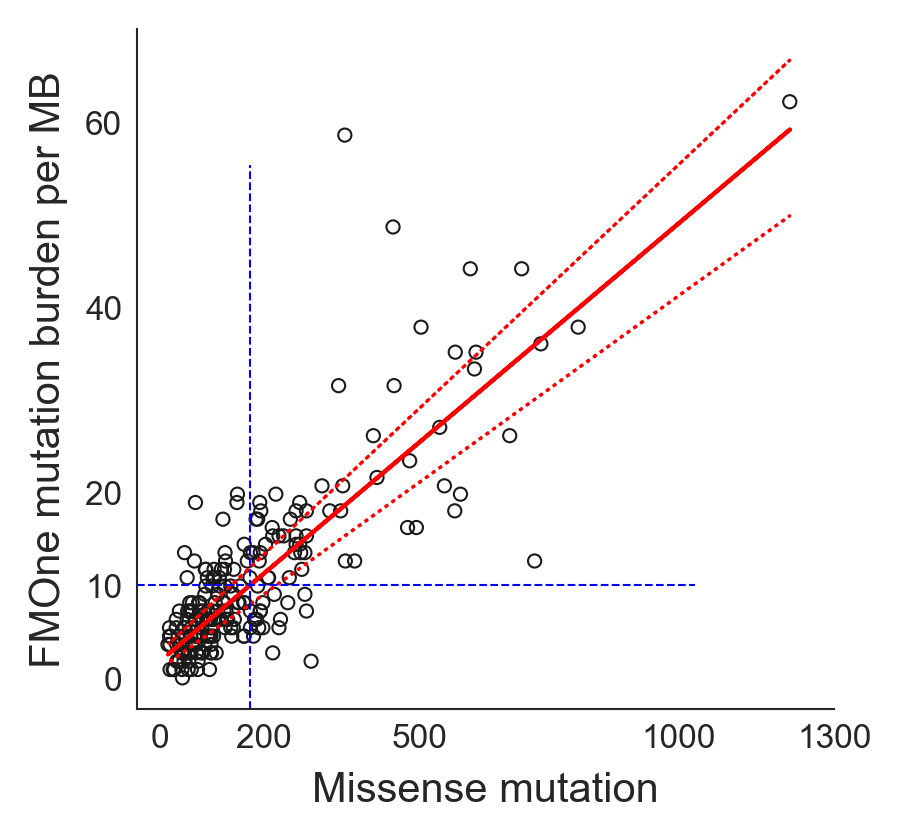

In [16]:
fig=plt.figure(figsize=(3,3))
ax=fig.add_subplot(111)
tmp_df=blca2018.copy()
val1,val2="Missense_Mutation","FMOne mutation burden per MB"
tmp_df=tmp_df.dropna(subset=[val1,val2])
x=tmp_df[val1]
y=tmp_df[val2]
ax.scatter(x,y,s=10,fc="None",ec="k",lw=0.5)

r,p=stats.pearsonr(x,y)
print("r= {:.3f}, P= {:.2e}".format(r,p))

y2=pb_para.loc["Intercept","EST"]+pb_para.loc["Slope","EST"]*x

ax.plot(x,y2,c="red",lw=1)

y3=pb_para.loc["Intercept","LCI"]+pb_para.loc["Slope","LCI"]*x
y4=pb_para.loc["Intercept","UCI"]+pb_para.loc["Slope","UCI"]*x

ax.plot(x,y3,c="red",ls="dotted",lw=0.75)
ax.plot(x,y4,c="red",ls="dotted",lw=0.75)

ax.axhline(y=10,xmin=0,xmax=0.8,color="blue",ls="dashed")

ax.axvline(x=cutoff1,ymin=0,ymax=0.8,color="blue",ls="dashed")

ax.set_xlabel("Missense mutation",fontsize=10)
ax.set_ylabel(val2,fontsize=10)
ax.set_xticks([0,200,500,1000,1300])
ax.set_yticks([0,10,20,40,60])
ax.tick_params(labelsize=8)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [17]:
blca2018["FM_high"]=(blca2018["FMOne mutation burden per MB"]>=10).astype(int)
blca2018["MM_high"]=(blca2018["Missense_Mutation"]>=cutoff1).astype(int)
ct=pd.crosstab(blca2018["FM_high"],blca2018["MM_high"])
ct                                                                  

MM_high,0,1
FM_high,,
0,118,19
1,22,59


In [18]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(blca2018["FM_high"],blca2018["MM_high"])

0.5942068464541905

# TMB cut-off by ROC

In [19]:
# ROC curve, AUC, explore optimal threshold
from sklearn.metrics import roc_curve,roc_auc_score,auc
flag="Responder"
value="Missense_Mutation"
plt_df=df0.copy()

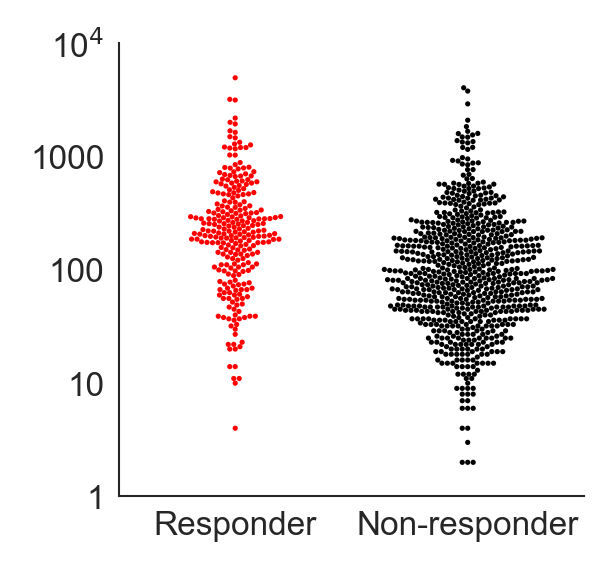

In [20]:
fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
sns_df=plt_df.copy()
cat=flag
val="Missense_Mutation_log10"
ax=sns.swarmplot(x=cat,y=val,data=sns_df,s=1.25,order=[1,0],palette=["red","black"])
ax.set_xlabel("")
ax.set_ylabel("")
ax.legend([])
ax.set_title("",fontsize=10)
ax.tick_params(axis="both",labelsize=6)

ax.set_xticklabels(["Responder","Non-responder"], rotation=0, fontsize=8)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

Youden index: TPR=0.65,　FPR=0.30,　Threshold=165.00


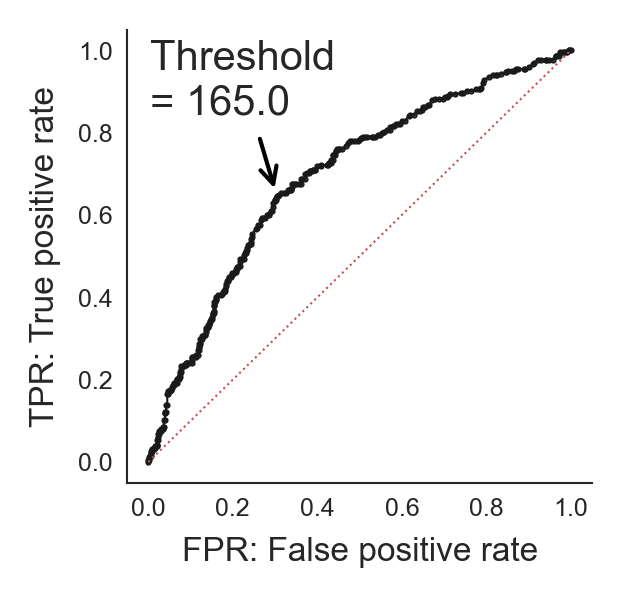

In [21]:
# plot ROC curve
plt_df=plt_df.loc[:,[flag,value]].dropna()
y_true=plt_df[flag]
y_score=plt_df[value]
fpr, tpr, thresholds = roc_curve(y_true, y_score)
auc=roc_auc_score(y_true, y_score)

fig=plt.figure(figsize=(2,2))
ax=fig.add_subplot(111)
ax.plot(fpr, tpr, marker='o',ms=0.5,c="k")
ax.set_xlabel('FPR: False positive rate',fontsize=8)
ax.set_ylabel('TPR: True positive rate',fontsize=8)
ax.plot(np.linspace(0,1), np.linspace(0,1), c="r",ls="dotted")
ax.tick_params(labelsize=6)

# Youden index
yd_idx = np.argmax( abs(tpr -fpr) )
yd_threshold = thresholds[yd_idx]
print("Youden index: TPR={:.2f},　FPR={:.2f},　Threshold={:.2f}".format(tpr[yd_idx],fpr[yd_idx],yd_threshold))

# plot with Threshold
arrow_dict = dict(color = "black",arrowstyle = "->")
ax.annotate("Threshold\n= {}".format(thresholds[yd_idx]),xy=(fpr[yd_idx],tpr[yd_idx]),
             size=10,xytext=(fpr[yd_idx]-0.3,tpr[yd_idx]+0.2), arrowprops = arrow_dict )

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

In [22]:
df0["TMB_high"]=(df0["Missense_Mutation"]>=cutoff1).astype(float)
df0["TMB_high2"]=(df0["Missense_Mutation"]>=yd_threshold).astype(float)

# Compare response rate

## irGS vs non irGS

In [23]:
df=df0.copy()

In [24]:
input_df=df.copy()
flag="Responder"
cat1="irGS"
value="Missense_Mutation_log10"
ct=pd.crosstab(input_df[flag],input_df[cat1])
ct=ct.loc[:,[1,0]]
ct

irGS,1,0
Responder,,
0.0,421,292
1.0,222,40


In [25]:
_,p=stats.fisher_exact(ct)
res=stats.chi2_contingency(ct,correction=False)
print("Fisher p= %.2e"%p)
print("Chi-square p= %.2e"%res[1])

Fisher p= 6.14e-15
Chi-square p= 6.24e-14


In [26]:
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    print(count,nobs)
    

222 643
40 332


In [27]:
ratios=[]
errors=[]
labels=[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

222/643
40/332


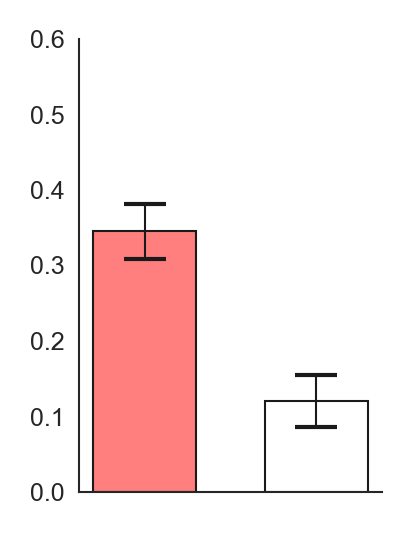

In [28]:
n=len(ratios)
left=range(n)
colors=["red","w"]
colors=[to_rgba(x,0.5) for x in colors]
fig=plt.figure(figsize=((1.3,2)))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)

ax.set_xticklabels([], rotation=0, fontsize=8)
ax.set_ylim(0,0.6)
ax.legend([])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## TMB high vs low

In [29]:
input_df=df.copy()
cat2="TMB_high"
ct=pd.crosstab(input_df[flag],input_df[cat2])
ct=ct.loc[:,[1,0]]
ct

TMB_high,1,0
Responder,,
0.0,210,503
1.0,162,100


In [30]:
_,p=stats.fisher_exact(ct)
res=stats.chi2_contingency(ct,correction=False)
print("Fisher p= %.2e"%p)
print("Chi-square p= %.2e"%res[1])

Fisher p= 1.08e-19
Chi-square p= 2.80e-20


In [31]:
ratios=[]
errors=[]
labels=[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

162/372
100/603


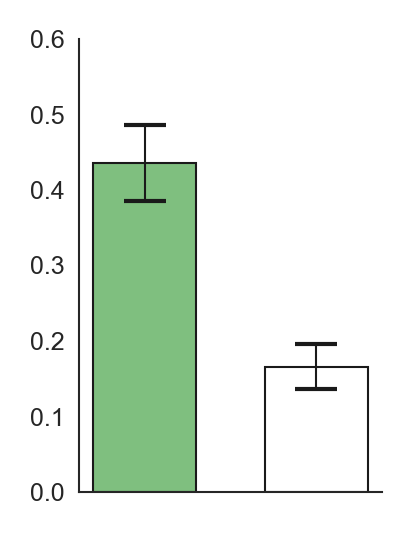

In [32]:
n=len(ratios)
left=range(n)
colors=["green","w"]
colors=[to_rgba(x,0.5) for x in colors]
fig=plt.figure(figsize=((1.3,2)))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)

ax.set_xticklabels([], rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,0.6)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## 2D plot

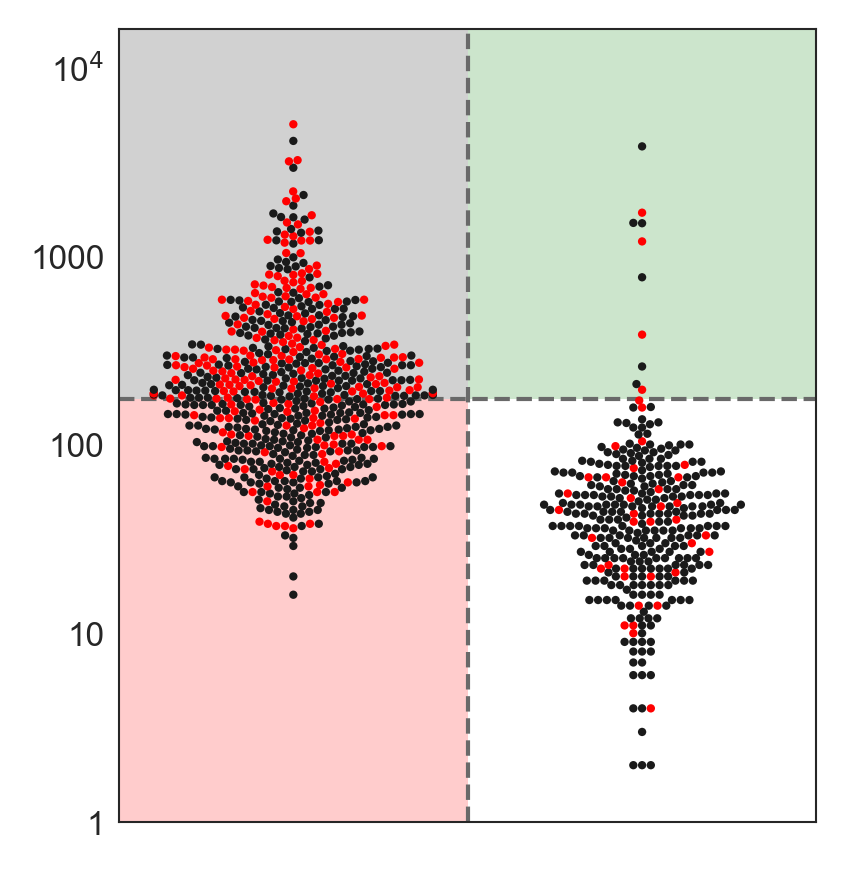

In [33]:
fig=plt.figure(figsize=(3,3.5))
ax=fig.add_subplot(111)
sns.swarmplot(x=cat1,y=value,data=df,
              s=2,ax=ax,hue=flag,hue_order=[0,1],
              palette=["k","red"],
             order=[1,0])
ax.set_ylabel("",fontsize=8)
ax.set_xlabel("")
ax.axhline(y=np.log10(cutoff1),c="dimgrey",lw=1,ls="dashed")
ax.axvline(x=0.5,c="dimgrey",lw=1,ls="dashed")
ax.tick_params(labelsize=6)
ax.set_xticklabels([])
ax.set_yticks([0,1,2,3,4])
ax.set_ylim(0,4.2)
ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8)
ax.legend([])

   
p1=patches.Rectangle(xy=(-0.5,0),width=1,height=np.log10(cutoff1+1),ec="w",fc="red",alpha=0.2,
                     linewidth=0)
p2=patches.Rectangle(xy=(-0.5,np.log10(cutoff1+1)),width=1,height=4.2-np.log10(cutoff1+1),
                      ec="w",fc="k",alpha=0.2,
                     linewidth=0)
p3=patches.Rectangle(xy=(0.5,np.log10(cutoff1+1)),width=1,height=4.2-np.log10(cutoff1+1),
                      ec="w",fc="green",alpha=0.2,
                     linewidth=0)

ax.add_patch(p1)
ax.add_patch(p2)
ax.add_patch(p3)

In [34]:
class4=[]
for idx in df.index:
    if df.loc[idx,cat2]==1:
        if df.loc[idx,cat1]==1:
            class4.append("TMB high\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB high\nnon-irGS")
        else:
            class4.append("und")
    elif df.loc[idx,cat2]==0:
        if df.loc[idx,cat1]==1:
            class4.append("TMB low\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB low\nnon-irGS")
        else:
            class4.append("und")   
df["class4"]=class4

In [35]:
ct4=pd.crosstab(df["class4"],df[flag]).T
ct4=ct4.reindex(['TMB high\nirGS', 'TMB high\nnon-irGS', 'TMB low\nirGS','TMB low\nnon-irGS'],axis=1)
ct4

class4,TMB high\nirGS,TMB high\nnon-irGS,TMB low\nirGS,TMB low\nnon-irGS
Responder,,,,
0.0,204,6,217,286
1.0,158,4,64,36


In [36]:
# compare between TMB-low groups
ct=ct4.loc[:, ["TMB low\nirGS","TMB low\nnon-irGS"]]
res=stats.chi2_contingency(ct,correction=False)
display(ct)
print("Chi-square p= %.2e"%res[1])

class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,217,286
1.0,64,36


Chi-square p= 1.34e-04


In [37]:
ratios=[]
errors=[]
labels=[]
for col in ct4.columns:
    count=ct4.loc[1,col]
    nobs=np.sum( ct4.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    
    ratios.append(ratio)   
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

158/362
4/10
64/281
36/322


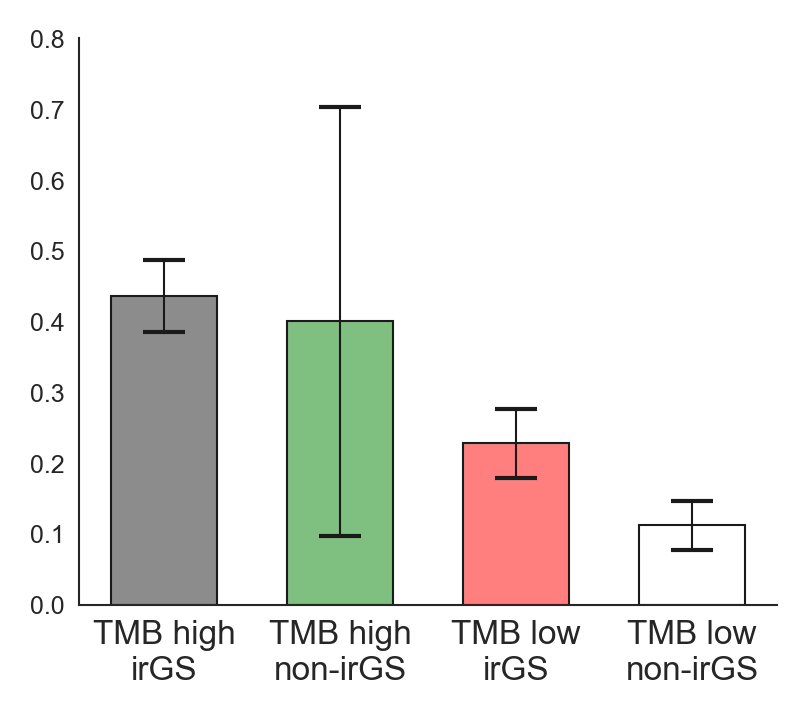

In [38]:
n=len(ratios)
left=range(n)
colors=["dimgrey","lightgrey"]*n
colors=["k","green","red","white"]
colors=[to_rgba(x, 0.5) for x in colors ]

fig=plt.figure(figsize=(3,2.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)
ax.set_xticklabels(labels, rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Logistic regression 

In [39]:
df=df0.copy()

In [40]:
Counter(df["irGS"])

Counter({1: 643, 0: 332})

In [41]:
Counter(df["TMB_high"])

Counter({1.0: 372, 0.0: 603})

In [42]:
Counter(df["CancerType"])

Counter({'Melanoma': 335,
         'Lung': 164,
         'Bladder': 263,
         'HNSCC': 118,
         'Others': 95})

In [43]:
df["CancerTypeR"]=df["CancerType"].replace(
        {'Melanoma':"1_Melanoma",
         'Lung': "3_Lung",
         'Bladder': "4_Bladder",
         'HNSCC': "2_Head_neck",
         'Others': "5_Others"})

In [44]:
Counter(df["Sex"])

Counter({'Female': 343, 'Male': 632})

In [45]:
df["Sex_male"]=(df["Sex"]=="Male").astype(int)

In [46]:
Counter(df["Age_high"])

Counter({0.0: 334,
         1.0: 341,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         nan: 1,
         n

In [47]:
Counter(df["ICI_single"])

Counter({1: 898, 0: 77})

In [48]:
Y="Responder"
categories=["irGS","TMB_high","CancerTypeR","ICI_single","Sex_male","Age_high",]

In [49]:
# univariate
univ_integrated=pd.DataFrame()

for cat in categories:
    input_df=df.copy()
    formula = Y+" ~ "+cat
    family = sm.families.Binomial()
    model = smf.glm(formula=formula, data=input_df, family=family)
    res = model.fit()
    res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
    add=res_df.iloc[1:,:]

    univ_integrated=pd.concat([univ_integrated,add])

univ_integrated.columns=["Odds ratio","CI 5%","CI 95%", "P-value"]

res_df=univ_integrated
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","P-value"]],3) )

for i in res_df["P-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,P-value
irGS,3.849,(2.66 - 5.56),0.000
TMB_high,3.880,(2.88 - 5.22),0.000
CancerTypeR[T.2_Head_neck],0.482,(0.29 - 0.81),0.006
CancerTypeR[T.3_Lung],0.896,(0.60 - 1.34),0.594
CancerTypeR[T.4_Bladder],0.762,(0.53 - 1.09),0.136
CancerTypeR[T.5_Others],0.333,(0.18 - 0.62),0.001
ICI_single,0.796,(0.48 - 1.32),0.376
Sex_male,1.238,(0.92 - 1.67),0.166
Age_high,1.066,(0.76 - 1.50),0.714


7.29e-13
3.38e-19
5.60e-03
5.94e-01
1.36e-01
6.08e-04
3.76e-01
1.66e-01
7.14e-01


In [50]:
# multivariate
categories=["irGS","TMB_high","CancerTypeR",]#"TCRA_tcell_fraction"]
input_df=df.copy()
res = smf.glm(formula = Y+" ~ "+"+".join(categories),
                  data = input_df,
                  family = sm.families.Binomial()).fit()

res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
res_df.columns=["Odds ratio","CI 5%","CI 95%", "p-value"]
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","p-value"]],3) )

for i in res_df["p-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,p-value
Intercept,0.139,(0.09 - 0.21),0.000
CancerTypeR[T.2_Head_neck],0.832,(0.48 - 1.45),0.514
CancerTypeR[T.3_Lung],1.172,(0.76 - 1.81),0.472
CancerTypeR[T.4_Bladder],0.880,(0.60 - 1.29),0.508
CancerTypeR[T.5_Others],0.874,(0.44 - 1.74),0.702
irGS,2.161,(1.39 - 3.37),0.001
TMB_high,2.678,(1.89 - 3.80),0.000


7.53e-20
5.14e-01
4.72e-01
5.08e-01
7.02e-01
6.50e-04
3.57e-08


## Forest Plot

In [51]:
ratios=[]
cils=[]
cihs=[]
labels=[]

0
1


[]

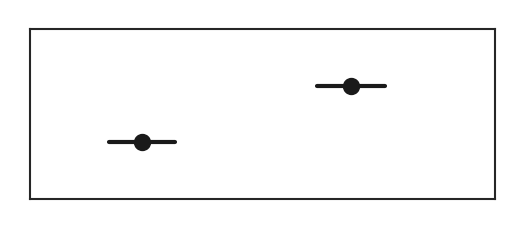

In [52]:
input_df=df.copy()
cat='irGS'
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
fig=plt.figure(figsize=(2,0.75))
ax=fig.add_subplot(1,1,1)
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    ax.scatter(x=ratio,y=i,c='k',s=10)
    ax.plot([cil,cih],[i,i],lw=1,c='k')

ax.set_xlim(0,0.5)
ax.set_ylim(-1,2)
ax.set_xticks([])
ax.set_yticks([])

0.0
1.0


[]

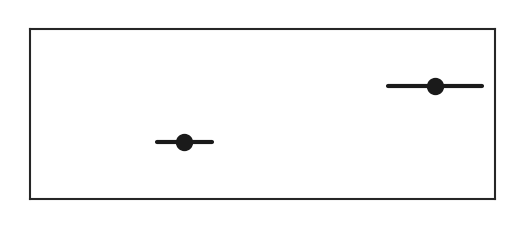

In [53]:
input_df=df.copy()
cat='TMB_high'
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
fig=plt.figure(figsize=(2,0.75))
ax=fig.add_subplot(1,1,1)
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    ax.scatter(x=ratio,y=i,c='k',s=10)
    ax.plot([cil,cih],[i,i],lw=1,c='k')

ax.set_xlim(0,0.5)
ax.set_ylim(-1,2)
ax.set_xticks([])
ax.set_yticks([])

1_Melanoma
2_Head_neck
3_Lung
4_Bladder
5_Others


[]

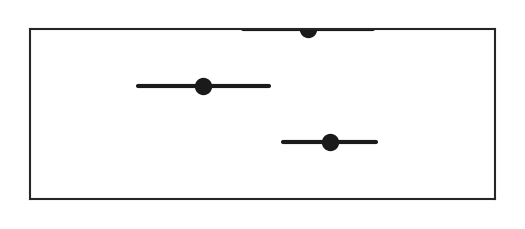

In [54]:
input_df=df.copy()
cat='CancerTypeR'
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
fig=plt.figure(figsize=(2,0.75))
ax=fig.add_subplot(1,1,1)
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    ax.scatter(x=ratio,y=i,c='k',s=10)
    ax.plot([cil,cih],[i,i],lw=1,c='k')

ax.set_xlim(0,0.5)
ax.set_ylim(-1,2)
ax.set_xticks([])
ax.set_yticks([])

0
1


[]

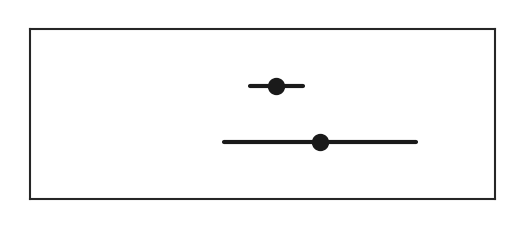

In [55]:
input_df=df.copy()
cat='ICI_single'
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
fig=plt.figure(figsize=(2,0.75))
ax=fig.add_subplot(1,1,1)
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    ax.scatter(x=ratio,y=i,c='k',s=10)
    ax.plot([cil,cih],[i,i],lw=1,c='k')

ax.set_xlim(0,0.5)
ax.set_ylim(-1,2)
ax.set_xticks([])
ax.set_yticks([])

0
1


[]

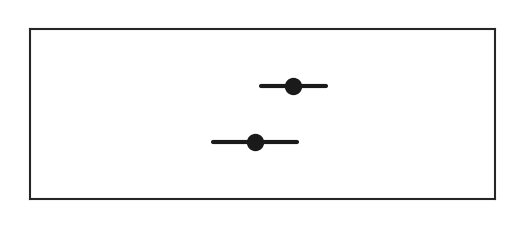

In [56]:
input_df=df.copy()
cat="Sex_male"
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
fig=plt.figure(figsize=(2,0.75))
ax=fig.add_subplot(1,1,1)
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    ax.scatter(x=ratio,y=i,c='k',s=10)
    ax.plot([cil,cih],[i,i],lw=1,c='k')

ax.set_xlim(0,0.5)
ax.set_ylim(-1,2)
ax.set_xticks([])
ax.set_yticks([])

0.0
1.0


[]

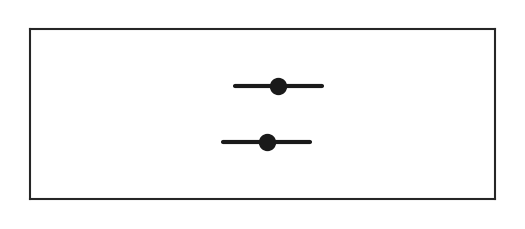

In [57]:
input_df=df.copy()
cat="Age_high"
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
fig=plt.figure(figsize=(2,0.75))
ax=fig.add_subplot(1,1,1)
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    ax.scatter(x=ratio,y=i,c='k',s=10)
    ax.plot([cil,cih],[i,i],lw=1,c='k')

ax.set_xlim(0,0.5)
ax.set_ylim(-1,2)
ax.set_xticks([])
ax.set_yticks([])

irGS_0
irGS_1
TMB_high_0.0
TMB_high_1.0
CancerTypeR_1_Melanoma
CancerTypeR_2_Head_neck
CancerTypeR_3_Lung
CancerTypeR_4_Bladder
CancerTypeR_5_Others
ICI_single_0
ICI_single_1
Sex_male_0
Sex_male_1
Age_high_0.0
Age_high_1.0


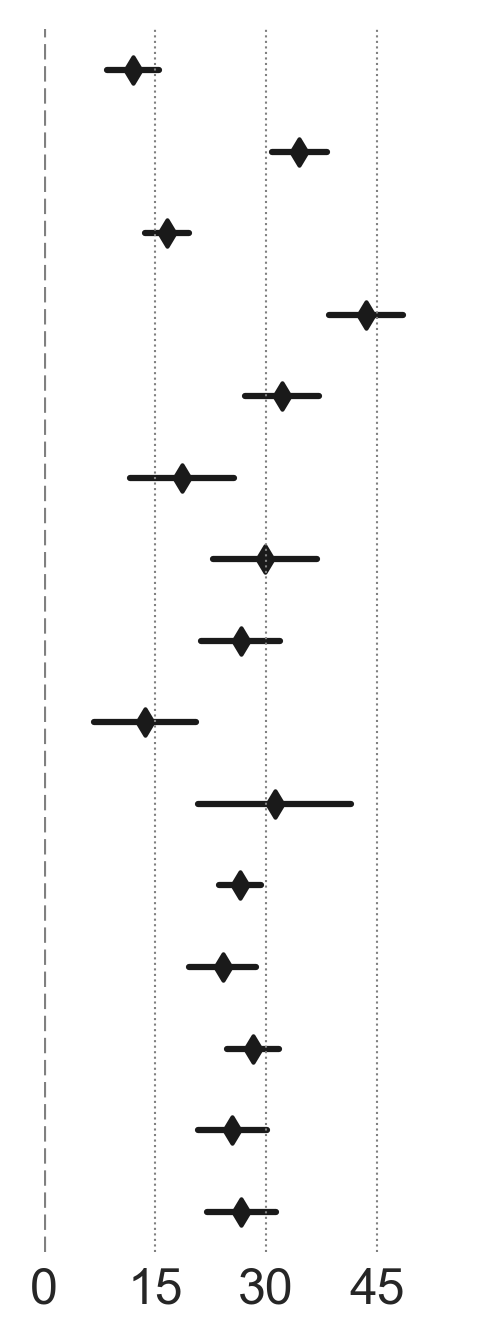

In [58]:
N=len(ratios)
fig=plt.figure(figsize=(1.75,5.4))
ax=fig.add_subplot(111)

for i in range(N):
    ax.scatter( ratios[i],i,c="k",s=20,marker='d')
    ax.plot([cils[i],cihs[i]],[i,i],lw=1.5,c='k' )
    print(labels[i])


ax.axvline(x=0,ls='dashed',c='grey',lw=1)
ax.axvline(x=0.15,ls='dotted',c='grey')
ax.axvline(x=0.30,ls='dotted',c='grey')
ax.axvline(x=0.45,ls='dotted',c='grey')
ax.set_xlim(0,0.55)
ax.set_ylim(-0.5,N-0.5)   
ax.set_xticks([0,0.15,0.30,0.45])
ax.set_xticklabels(['0','15','30','45'],fontsize=12)
ax.set_yticks([])
ax.invert_yaxis()
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['bottom'].set_visible(False)
ax.spines['left'  ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [59]:
for i in ratios:
    print( '{:.1f}'.format(i*100) )

12.0
34.5
16.6
43.5
32.2
18.6
29.9
26.6
13.7
31.2
26.5
24.2
28.3
25.4
26.7


### Using TMB log10 as a continuous value

In [60]:
categories=["irGS","Missense_Mutation_log10","CancerTypeR","ICI_single","Sex_male","Age_high",]

In [61]:
# univariate
univ_integrated=pd.DataFrame()

for cat in categories:
    input_df=df.copy()
    formula = Y+" ~ "+cat
    family = sm.families.Binomial()
    model = smf.glm(formula=formula, data=input_df, family=family)
    res = model.fit()
    res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
    add=res_df.iloc[1:,:]

    univ_integrated=pd.concat([univ_integrated,add])

univ_integrated.columns=["Odds ratio","CI 5%","CI 95%", "P-value"]

res_df=univ_integrated
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","P-value"]],3) )

for i in res_df["P-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,P-value
irGS,3.849,(2.66 - 5.56),0.000
Missense_Mutation_log10,3.923,(2.87 - 5.37),0.000
CancerTypeR[T.2_Head_neck],0.482,(0.29 - 0.81),0.006
CancerTypeR[T.3_Lung],0.896,(0.60 - 1.34),0.594
CancerTypeR[T.4_Bladder],0.762,(0.53 - 1.09),0.136
CancerTypeR[T.5_Others],0.333,(0.18 - 0.62),0.001
ICI_single,0.796,(0.48 - 1.32),0.376
Sex_male,1.238,(0.92 - 1.67),0.166
Age_high,1.066,(0.76 - 1.50),0.714


7.29e-13
1.28e-17
5.60e-03
5.94e-01
1.36e-01
6.08e-04
3.76e-01
1.66e-01
7.14e-01


In [62]:
# multivariate　using TMB log10
categories=["irGS","Missense_Mutation_log10","CancerTypeR",]#"TCRA_tcell_fraction"]
input_df=df.copy()
res = smf.glm(formula = Y+" ~ "+"+".join(categories),
                  data = input_df,
                  family = sm.families.Binomial()).fit()

res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
res_df.columns=["Odds ratio","CI 5%","CI 95%", "p-value"]
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","p-value"]],3) )

for i in res_df["p-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,p-value
Intercept,0.027,(0.01 - 0.06),0.000
CancerTypeR[T.2_Head_neck],0.837,(0.48 - 1.46),0.528
CancerTypeR[T.3_Lung],1.178,(0.76 - 1.81),0.458
CancerTypeR[T.4_Bladder],0.896,(0.61 - 1.31),0.572
CancerTypeR[T.5_Others],0.889,(0.44 - 1.79),0.741
irGS,1.890,(1.19 - 3.00),0.007
Missense_Mutation_log10,2.771,(1.86 - 4.12),0.000


1.26e-16
5.28e-01
4.58e-01
5.72e-01
7.41e-01
7.11e-03
4.86e-07


# Using optimal TMB cutoff

In [63]:
df=df0.copy()

## TMB high vs low

In [64]:
input_df=df.copy()
cat2="TMB_high2"
ct=pd.crosstab(input_df[flag],input_df[cat2])
ct=ct.loc[:,[1,0]]
ct

TMB_high2,1,0
Responder,,
0.0,217,496
1.0,169,93


In [65]:
_,p=stats.fisher_exact(ct)
res=stats.chi2_contingency(ct,correction=False)
print("Fisher p= %.2e"%p)
print("Chi-square p= %.2e"%res[1])

Fisher p= 1.27e-21
Chi-square p= 5.27e-22


In [66]:
ratios=[]
errors=[]
labels=[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

169/386
93/589


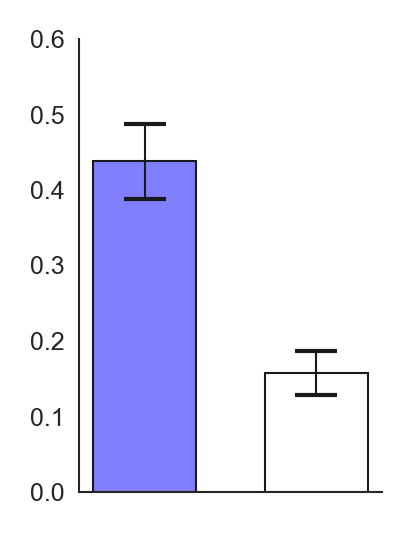

In [67]:
n=len(ratios)
left=range(n)
colors=["blue","w"]
colors=[to_rgba(x,0.5) for x in colors]
fig=plt.figure(figsize=((1.3,2)))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)

ax.set_xticklabels([], rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,0.6)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## 2D plot

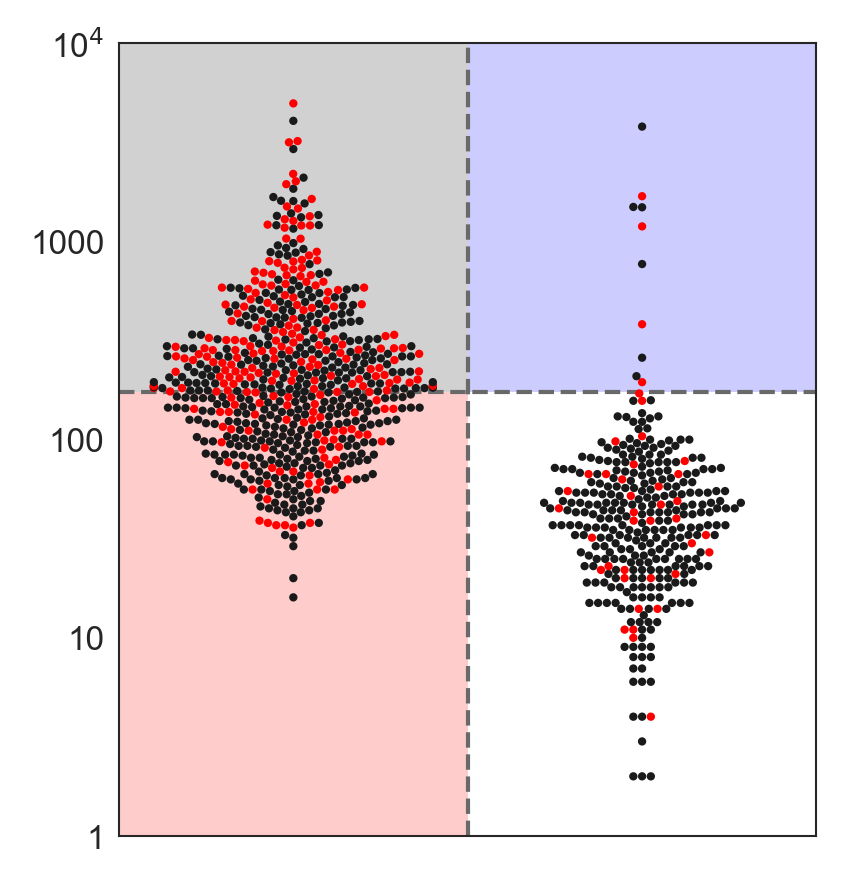

In [68]:
fig=plt.figure(figsize=(3,3.5))
ax=fig.add_subplot(111)
sns.swarmplot(x=cat1,y=value,data=df,
              s=2,ax=ax,hue=flag,hue_order=[0,1],
              palette=["k","red"],
             order=[1,0])
ax.set_ylabel("",fontsize=8)
ax.set_xlabel("")
ax.axhline(y=np.log10(cutoff1),c="dimgrey",lw=1,ls="dashed")
ax.axvline(x=0.5,c="dimgrey",lw=1,ls="dashed")
ax.tick_params(labelsize=6)
ax.set_xticklabels([])
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8)
ax.legend([])

p1=patches.Rectangle(xy=(-0.5,0),width=1,height=np.log10(cutoff1+1),ec="w",fc="red",alpha=0.2,
                 linewidth=0)
p2=patches.Rectangle(xy=(-0.5,np.log10(cutoff1+1)),width=1,height=4.2-np.log10(cutoff1+1),
                      ec="w",fc="k",alpha=0.2,
                     linewidth=0)
p3=patches.Rectangle(xy=(0.5,np.log10(cutoff1+1)),width=1,height=4.2-np.log10(cutoff1+1),
                      ec="w",fc="blue",alpha=0.2,
                     linewidth=0)
ax.add_patch(p1)
ax.add_patch(p2)
ax.add_patch(p3)


In [69]:
class4=[]
for idx in df.index:
    if df.loc[idx,cat2]==1:
        if df.loc[idx,cat1]==1:
            class4.append("TMB high\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB high\nnon-irGS")
        else:
            class4.append("und")
    elif df.loc[idx,cat2]==0:
        if df.loc[idx,cat1]==1:
            class4.append("TMB low\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB low\nnon-irGS")
        else:
            class4.append("und")   
df["class4"]=class4

In [70]:
ct4=pd.crosstab(df["class4"],df[flag]).T
ct4=ct4.reindex(['TMB high\nirGS', 'TMB high\nnon-irGS', 'TMB low\nirGS','TMB low\nnon-irGS'],axis=1)
ct4

class4,TMB high\nirGS,TMB high\nnon-irGS,TMB low\nirGS,TMB low\nnon-irGS
Responder,,,,
0.0,211,6,210,286
1.0,164,5,58,35


In [71]:
# compare between TMB-low groups
ct=ct4.loc[:, ["TMB low\nirGS","TMB low\nnon-irGS"]]
res=stats.chi2_contingency(ct,correction=False)
display(ct)
print("Chi-square p= %.2e"%res[1])

class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,210,286
1.0,58,35


Chi-square p= 3.72e-04


In [72]:
ratios=[]
errors=[]
labels=[]
for col in ct4.columns:
    count=ct4.loc[1,col]
    nobs=np.sum( ct4.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    
    ratios.append(ratio)   
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

164/375
5/11
58/268
35/321


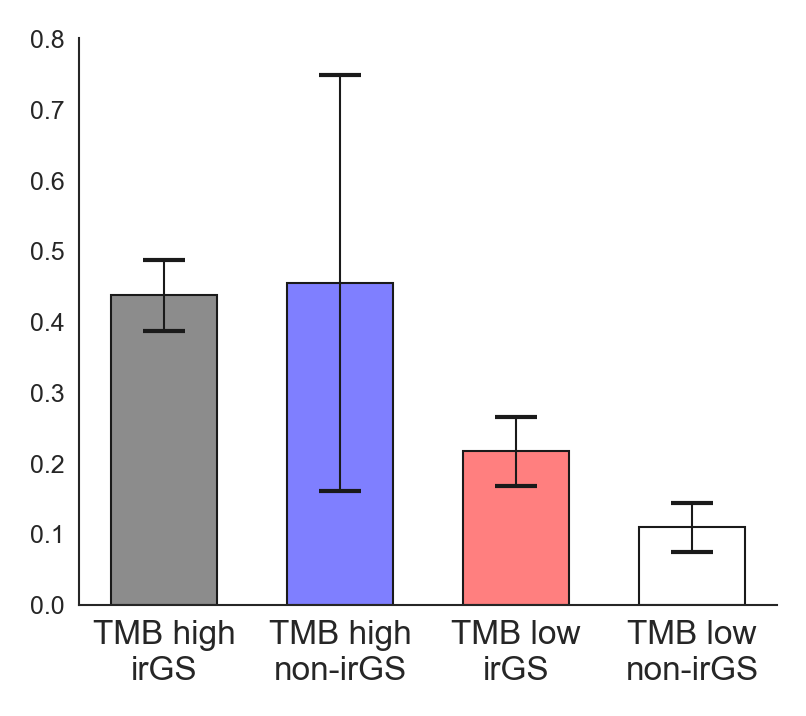

In [73]:
n=len(ratios)
left=range(n)
colors=["dimgrey","lightgrey"]*n
colors=["k","blue","red","white"]
colors=[to_rgba(x, 0.5) for x in colors ]

fig=plt.figure(figsize=(3,2.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)
ax.set_xticklabels(labels, rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,0.8)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Logistic regression 

In [74]:
Counter(df["irGS"])

Counter({1: 643, 0: 332})

In [75]:
Counter(df["TMB_high2"])

Counter({1.0: 386, 0.0: 589})

In [76]:
Counter(df["CancerType"])

Counter({'Melanoma': 335,
         'Lung': 164,
         'Bladder': 263,
         'HNSCC': 118,
         'Others': 95})

In [77]:
df["CancerTypeR"]=df["CancerType"].replace(
        {'Melanoma':"1_Melanoma",
         'Lung': "3_Lung",
         'Bladder': "4_Bladder",
         'HNSCC': "2_Head_neck",
         'Others': "5_Others"})

In [78]:
Counter(df["Sex"])

Counter({'Female': 343, 'Male': 632})

In [79]:
Counter(df["ICI_single"])

Counter({1: 898, 0: 77})

In [80]:
df["Sex_male"]=(df["Sex"]=="Male").astype(int)

In [81]:
Y="Responder"
categories=["irGS","TMB_high2","CancerTypeR",'ICI_single',"Sex_male","Age_high"]

In [82]:
# univariate
univ_integrated=pd.DataFrame()

for cat in categories:
    input_df=df.copy()
    formula = Y+" ~ "+cat
    family = sm.families.Binomial()
    model = smf.glm(formula=formula, data=input_df, family=family)
    res = model.fit()
    res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
    add=res_df.iloc[1:,:]

    univ_integrated=pd.concat([univ_integrated,add])

univ_integrated.columns=["Odds ratio","CI 5%","CI 95%", "P-value"]

res_df=univ_integrated
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","P-value"]],3) )

for i in res_df["P-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,P-value
irGS,3.849,(2.66 - 5.56),0.000
TMB_high2,4.154,(3.08 - 5.60),0.000
CancerTypeR[T.2_Head_neck],0.482,(0.29 - 0.81),0.006
CancerTypeR[T.3_Lung],0.896,(0.60 - 1.34),0.594
CancerTypeR[T.4_Bladder],0.762,(0.53 - 1.09),0.136
CancerTypeR[T.5_Others],0.333,(0.18 - 0.62),0.001
ICI_single,0.796,(0.48 - 1.32),0.376
Sex_male,1.238,(0.92 - 1.67),0.166
Age_high,1.066,(0.76 - 1.50),0.714


7.29e-13
1.06e-20
5.60e-03
5.94e-01
1.36e-01
6.08e-04
3.76e-01
1.66e-01
7.14e-01


In [83]:
# multivariate
categories=["irGS","TMB_high2","CancerTypeR"]
input_df=df.copy()
res = smf.glm(formula = Y+" ~ "+"+".join(categories),
                  data = input_df,
                  family = sm.families.Binomial()).fit()

res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
res_df.columns=["Odds ratio","CI 5%","CI 95%", "p-value"]
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","p-value"]],3) )

for i in res_df["p-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,p-value
Intercept,0.136,(0.09 - 0.21),0.000
CancerTypeR[T.2_Head_neck],0.842,(0.48 - 1.47),0.544
CancerTypeR[T.3_Lung],1.189,(0.77 - 1.83),0.435
CancerTypeR[T.4_Bladder],0.908,(0.62 - 1.33),0.621
CancerTypeR[T.5_Others],0.892,(0.45 - 1.78),0.745
irGS,2.007,(1.28 - 3.15),0.002
TMB_high2,2.944,(2.06 - 4.21),0.000


4.08e-20
5.44e-01
4.35e-01
6.21e-01
7.45e-01
2.40e-03
3.21e-09


### Forest Plot

In [84]:
ratios=[]
cils=[]
cihs=[]
labels=[]

In [85]:
input_df=df.copy()
cat='irGS'
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    
input_df=df.copy()
cat='TMB_high2'
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    
ratios.append(np.nan)
cils.append(np.nan)
cihs.append(np.nan)
labels.append('')

input_df=df.copy()
cat='CancerTypeR'
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    
input_df=df.copy()
cat='ICI_single'
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    
input_df=df.copy()
cat="Sex_male"
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    
input_df=df.copy()
cat="Age_high"
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )  


0
1
0.0
1.0
1_Melanoma
2_Head_neck
3_Lung
4_Bladder
5_Others
0
1
0
1
0.0
1.0


irGS_0
irGS_1
TMB_high2_0.0
TMB_high2_1.0

CancerTypeR_1_Melanoma
CancerTypeR_2_Head_neck
CancerTypeR_3_Lung
CancerTypeR_4_Bladder
CancerTypeR_5_Others
ICI_single_0
ICI_single_1
Sex_male_0
Sex_male_1
Age_high_0.0
Age_high_1.0


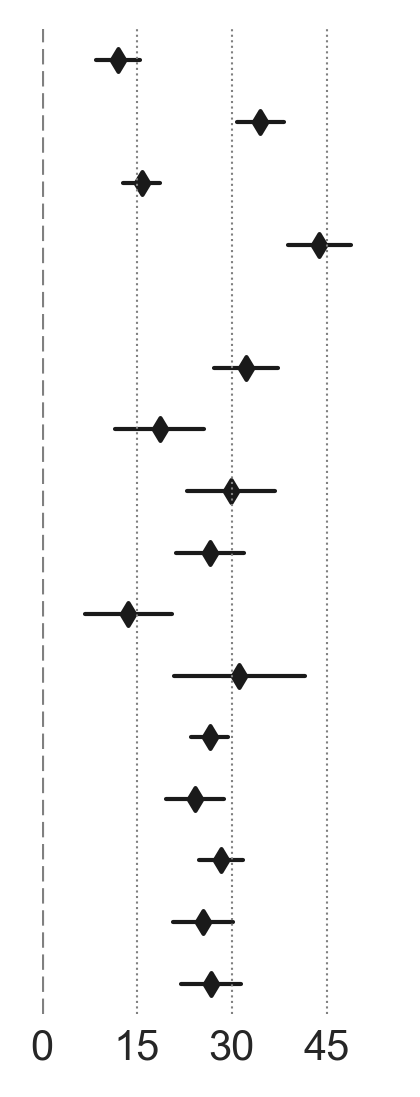

In [86]:
N=len(ratios)
fig=plt.figure(figsize=(1.5,4.35))
ax=fig.add_subplot(111)

for i in range(N):
    ax.scatter( ratios[i],i,c="k",s=15,marker='d' )
    ax.plot([cils[i],cihs[i]],[i,i],lw=1,c='k' )
    print(labels[i])


ax.axvline(x=0,ls='dashed',c='grey',lw=1)
ax.axvline(x=0.15,ls='dotted',c='grey')
ax.axvline(x=0.30,ls='dotted',c='grey')
ax.axvline(x=0.45,ls='dotted',c='grey')
ax.set_xlim(0,0.55)
ax.set_ylim(-0.5,N-0.5)   
ax.set_xticks([0,0.15,0.30,0.45])
ax.set_xticklabels(['0','15','30','45'],fontsize=10)
ax.set_yticks([])
ax.invert_yaxis()
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['bottom'].set_visible(False)
ax.spines['left'  ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [87]:
for i in ratios:
    print( '{:.1f}'.format(i*100) )

12.0
34.5
15.8
43.8
nan
32.2
18.6
29.9
26.6
13.7
31.2
26.5
24.2
28.3
25.4
26.7




# Response per subtype

In [88]:
df=df0.copy()

In [89]:
ct=pd.crosstab(df["Responder"],df["Tumor genomic subtype"])
ct=ct.loc[:,cluster_order2]
ct

Tumor genomic subtype,SMK,UVL,APB,MRD,POL,HRD,GNS,AGE,UND
Responder,,,,,,,,,
0.0,72,155,185,0,0,94,23,148,36
1.0,44,94,75,6,1,16,3,16,7


44/116
94/249
75/260
6/6
1/1
16/110
3/26
16/164
7/43


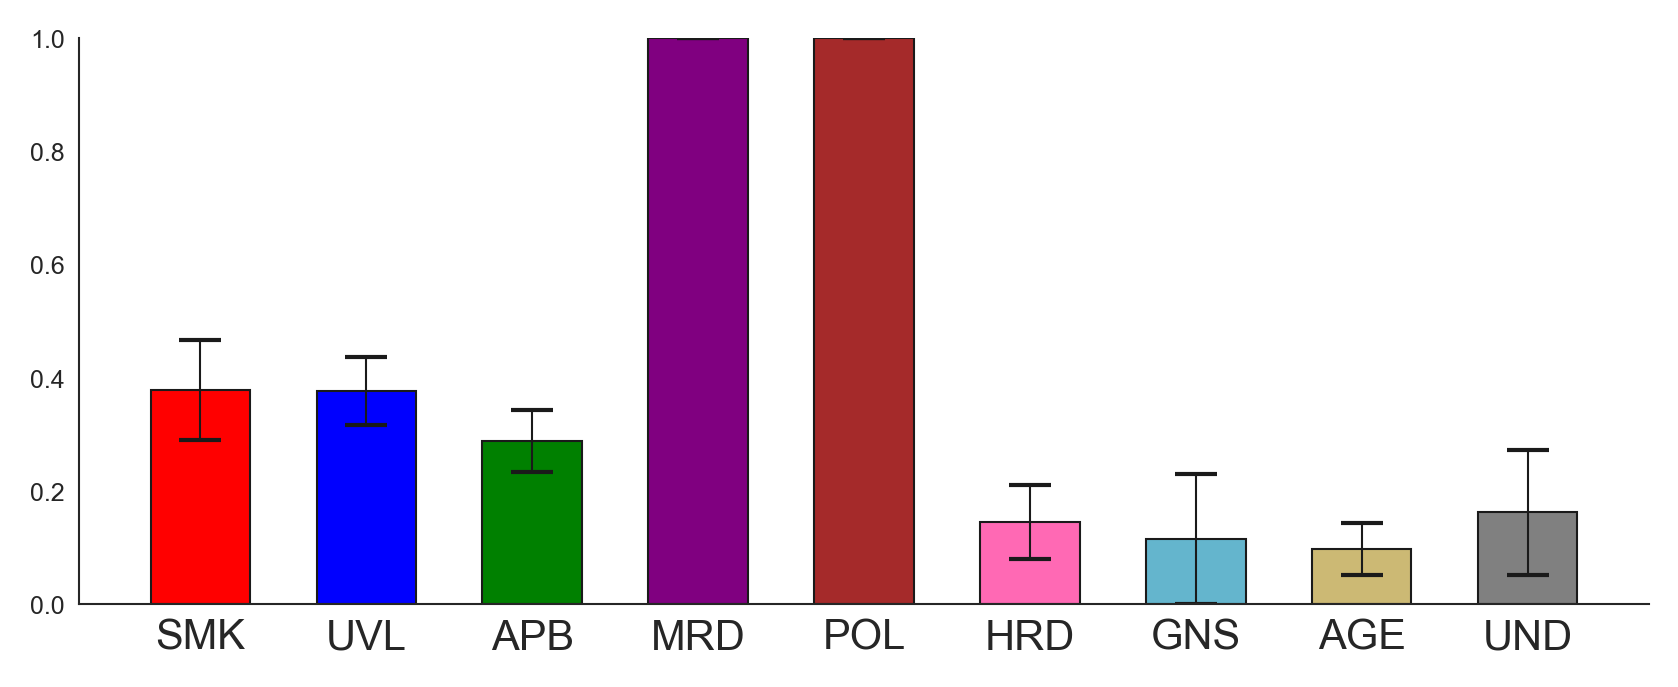

In [90]:
# bar plot with binomial confidence interval
ratios,errors,labels=[],[],[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    print(str(count)+"/"+str(nobs))

n=len(ratios)
left=range(n)
colors=cluster_colors2

fig=plt.figure(figsize=(n*0.75,2.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)  
ax.set_xticklabels(labels, rotation=0, fontsize=10)
ax.legend([])
ax.set_ylim(0,1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [91]:
ct=pd.crosstab(df["CancerType"],df["Tumor genomic subtype"])
ct.loc[["Melanoma","HNSCC","Lung","Bladder","Others"],cluster_order2]

Tumor genomic subtype,SMK,UVL,APB,MRD,POL,HRD,GNS,AGE,UND
CancerType,,,,,,,,,
Melanoma,2,247,0,0,0,33,12,24,17
HNSCC,14,2,38,0,0,15,0,43,6
Lung,91,0,18,0,0,18,6,26,5
Bladder,8,0,191,4,0,17,0,31,12
Others,1,0,13,2,1,27,8,40,3


# Per Drug type

In [92]:
df=df0.copy()

In [93]:
cat1="irGS"
cat2="TMB_high"

class4=[]
for idx in df.index:
    if df.loc[idx,cat2]==1:
        if df.loc[idx,cat1]==1:
            class4.append("TMB high\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB high\nnon-irGS")
        else:
            class4.append("und")
    elif df.loc[idx,cat2]==0:
        if df.loc[idx,cat1]==1:
            class4.append("TMB low\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB low\nnon-irGS")
        else:
            class4.append("und")   
df["class4"]=class4

In [94]:
df[ df["Treatment"]=='PD1/PDL1' ]

,Reference,Age,Sex,CancerType,CancerType details,Treatment,Best objective response,Responder,Tumor genomic subtype,TGS details,irGS,Missense_Mutation,Missense_Mutation_log10,TMB_high,TMB_high2,Age_high,ICI_single,class4
BLADDER-15330_CCPM_0700629,"Miao, NatGen 2018",69.0,Male,Bladder,BLCA,PD1/PDL1,PR,1.0,SMK,SMK:4,1,115.0,2.064458,0.0,0.0,1.0,1,TMB low\nirGS
SU2C-1006,"Miao, NatGen 2018",74.0,Female,Lung,NSCLC,PD1/PDL1,PD,0.0,SMK,SMK:4,1,63.0,1.806180,0.0,0.0,1.0,1,TMB low\nirGS
SU2C-1016,"Miao, NatGen 2018",72.0,Female,Lung,NSCLC,PD1/PDL1,SD,0.0,SMK,SMK:4,1,143.0,2.158362,0.0,0.0,1.0,1,TMB low\nirGS
SU2C-1017,"Miao, NatGen 2018",54.0,Female,Lung,NSCLC,PD1/PDL1,PR,1.0,SMK,SMK:4,1,794.0,2.900367,1.0,1.0,0.0,1,TMB high\nirGS
SU2C-1022,"Miao, NatGen 2018",NaN,Male,Lung,NSCLC,PD1/PDL1,SD,0.0,SMK,SMK:4,1,161.0,2.209515,0.0,0.0,NaN,1,TMB low\nirGS
SU2C-1026,"Miao, NatGen 2018",NaN,Female,Lung,NSCLC,PD1/PDL1,PR,1.0,SMK,SMK:4,1,129.0,2.113943,0.0,0.0,NaN,1,TMB low\nirGS
SU2C-1029,"Miao, NatGen 2018",NaN,Female,Lung,NSCLC,PD1/PDL1,PR,1.0,SMK,SMK:4,1,253.0,2.404834,1.0,1.0,NaN,1,TMB high\nirGS
SU2C-1034,"Miao, NatGen 2018",NaN,Male,Lung,NSCLC,PD1/PDL1,SD,0.0,SMK,SMK:4,1,685.0,2.836324,1.0,1.0,NaN,1,TMB high\nirGS
SU2C-1037,"Miao, NatGen 2018",NaN,Male,Lung,NSCLC,PD1/PDL1,SD,0.0,SMK,"SMK:3,HRD:1",1,92.0,1.968483,0.0,0.0,NaN,1,TMB low\nirGS
SU2C-1004,"Miao, NatGen 2018",61.0,Male,Lung,NSCLC,PD1/PDL1,SD,0.0,SMK,"SMK:3,AGE:1",1,84.0,1.929419,0.0,0.0,0.0,1,TMB low\nirGS


In [95]:
Counter(df["Treatment"])

Counter({'CTLA4': 117,
         'PD1': 500,
         'CTLA4->PD1': 18,
         'CTLA4+PD1': 49,
         'PDL1': 220,
         'PD1/PDL1': 61,
         'CTLA4+PD1/PDL1': 10})

In [96]:
df1=df[df["Treatment"]=="PD1"]
df2=df[df["Treatment"]=="PDL1"]
df3=df[df["Treatment"].isin(["CTLA4",'CTLA4->PD1',"CTLA4+PDL1","CTLA4+PD1","CTLA4+PD1/PDL1"])]
dfs=[df1,df2,df3]

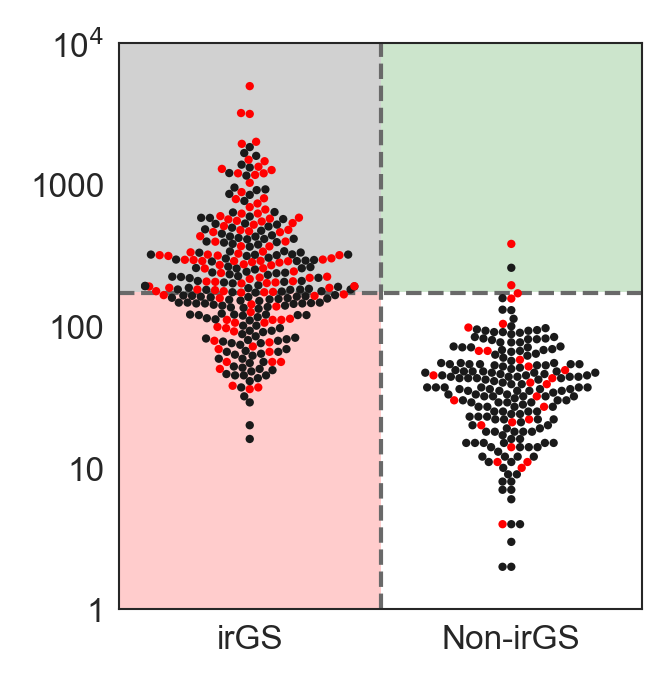

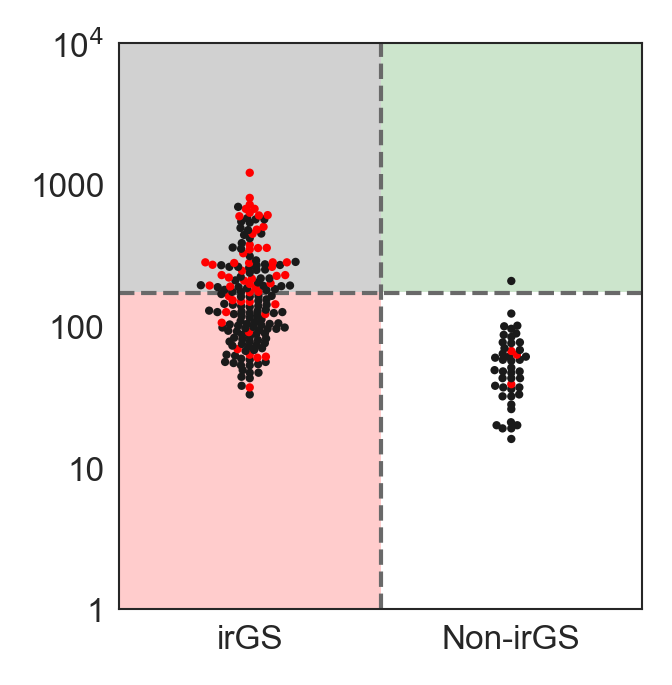

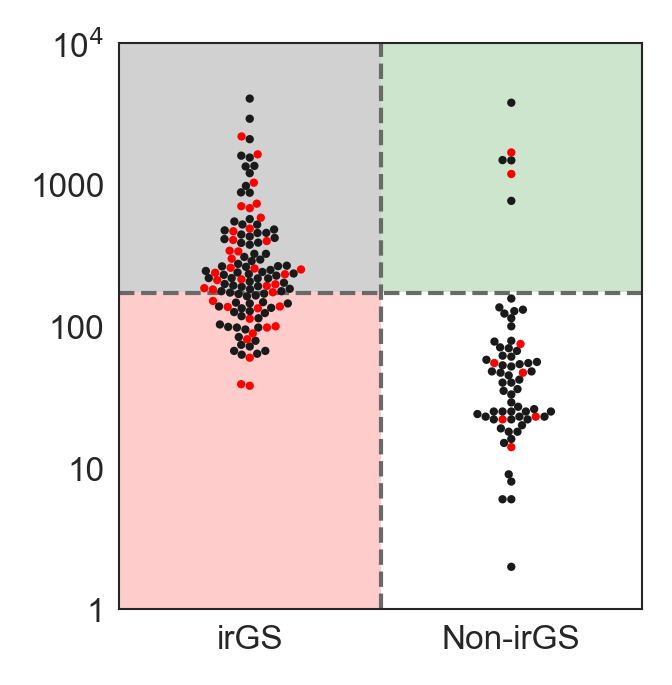

In [97]:
flag="Responder"
cat1="irGS"
cat2="TMB_high"
value="Missense_Mutation_log10"
for plt_df in dfs:
    fig=plt.figure(figsize=(2.25,2.5))
    ax=fig.add_subplot(111)
    sns.swarmplot(x=cat1,y=value,data=plt_df,
                  s=2,ax=ax,hue=flag,hue_order=[0,1],
                  palette=["k","red"],
                 order=[1,0])
    ax.set_ylabel("",fontsize=8)
    ax.set_xlabel("")
    ax.axhline(y=np.log10(173),c="dimgrey",lw=1,ls="dashed")
    ax.axvline(x=0.5,c="dimgrey",lw=1,ls="dashed")
    ax.tick_params(labelsize=6)
    ax.set_xticklabels(["irGS","Non-irGS"], rotation=0, fontsize=8)
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8)
    ax.legend([])
    p1=patches.Rectangle(xy=(-0.5,0),width=1,height=np.log10(cutoff1+1),ec="w",fc="red",alpha=0.2,
                     linewidth=0)
    p2=patches.Rectangle(xy=(-0.5,np.log10(cutoff1+1)),width=1,height=4.2-np.log10(cutoff1+1),
                          ec="w",fc="k",alpha=0.2,
                         linewidth=0)
    p3=patches.Rectangle(xy=(0.5,np.log10(cutoff1+1)),width=1,height=4.2-np.log10(cutoff1+1),
                          ec="w",fc="green",alpha=0.2,
                         linewidth=0)
    ax.add_patch(p1)
    ax.add_patch(p2)
    ax.add_patch(p3)

PD1 n= 500
85/179
2/3
30/119
24/199



class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,89,175
1.0,30,24


chisquare p= 0.00251
Fisher p= 0.00327

PDL1 n= 220
37/81
0/1
15/93
3/45



class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,78,42
1.0,15,3


chisquare p= 0.122
Fisher p= 0.178

CTLA4 n= 194
25/83
2/6
13/43
6/62



class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,30,56
1.0,13,6


chisquare p= 0.00714
Fisher p= 0.00982



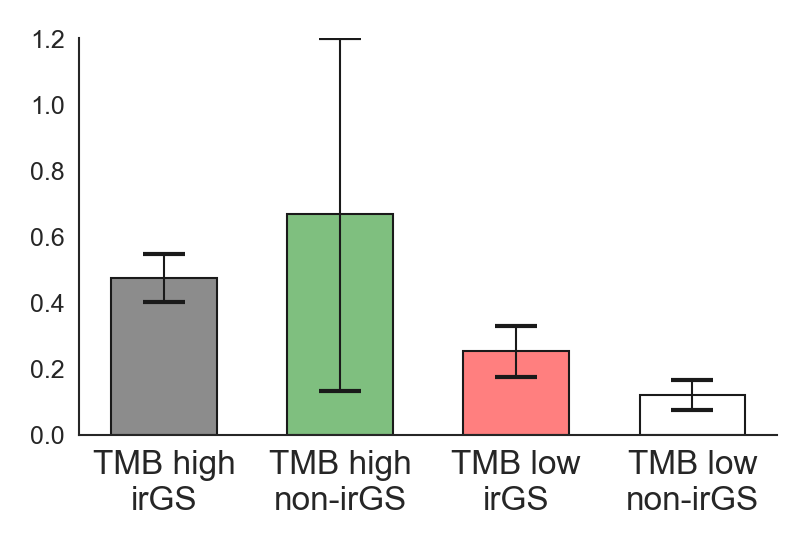

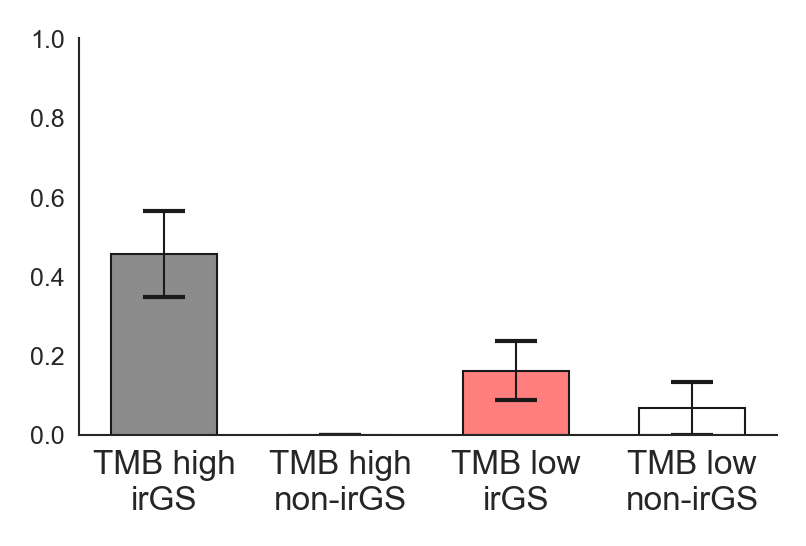

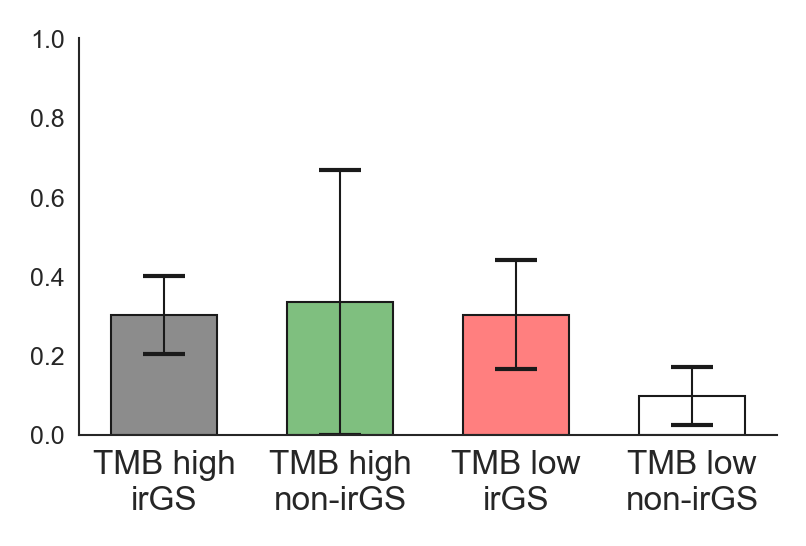

In [98]:
for i,plt_df in enumerate(dfs):
    print(plt_df["Treatment"].unique()[0],"n=", plt_df.shape[0])
    ct4=pd.crosstab(plt_df["class4"],plt_df[flag]).T
    ratios=[]
    errors=[]
    labels=[]
    for col in ct4.columns:
        count=ct4.loc[1,col]
        nobs=np.sum( ct4.loc[:,col])
        ratio=count/nobs
        cil,cih=proportion_confint(count,nobs,alpha=0.05)

        ratios.append(ratio)   
        errors.append(np.array(cil-ratio, cih-ratio))
        labels.append(col)
        print(str(count)+"/"+str(nobs))
    else:
        print()
    
    n=len(ratios)
    left=range(n)
    colors=["k","green","red","white"]
    colors=[to_rgba(x, 0.5) for x in colors ]

    fig=plt.figure(figsize=(3,1.75))
    ax=fig.add_subplot(111)
    ax.bar(x=left,height=ratios,yerr=errors,
           tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
    ax.tick_params(labelsize=6)            
    ax.set_xticklabels(labels, rotation=0, fontsize=8)
    ax.legend([])
    ax.set_ylim(0,1)
    if i==0:
        ax.set_ylim(0,1.2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ct=ct4.reindex(["TMB low\nirGS","TMB low\nnon-irGS"],axis=1)
    res=stats.chi2_contingency(ct,correction=False)
    res2=stats.fisher_exact(ct)
    display(ct)
    print("chisquare p= %.3g"%res[1])
    print("Fisher p= %.3g"%res2[1],end="\n\n")

# KEYNOTEs only

In [99]:
df=df0[df0["Reference"]=='Cristescu, Science 2018']
df.shape

(311, 17)

In [100]:
input_df=df.copy()
flag="Responder"
cat1="irGS"
value="Missense_Mutation_log10"
ct=pd.crosstab(input_df[flag],input_df[cat1])
ct=ct.loc[:,[1,0]]
ct

irGS,1,0
Responder,,
0.0,102,135
1.0,56,18


In [101]:
_,p=stats.fisher_exact(ct)
res=stats.chi2_contingency(ct,correction=False)
print("Fisher p= %.2e"%p)
print("Chi-square p= %.2e"%res[1])

Fisher p= 1.11e-06
Chi-square p= 9.46e-07


In [102]:
ratios=[]
errors=[]
labels=[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

56/158
18/153


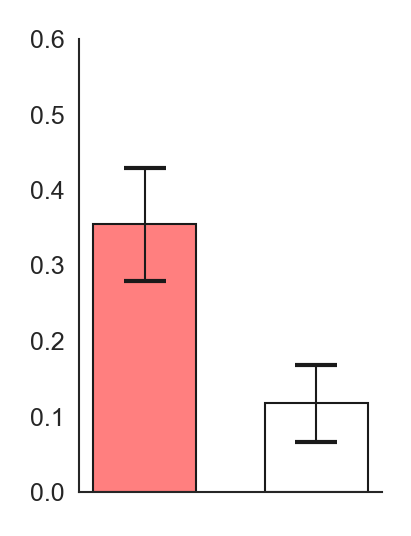

In [103]:
n=len(ratios)
left=range(n)
colors=["red","w"]
colors=[to_rgba(x,0.5) for x in colors]
fig=plt.figure(figsize=((1.3,2)))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)

ax.set_xticklabels([], rotation=0, fontsize=8)
ax.set_ylim(0,0.6)
ax.legend([])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [104]:
input_df=df.copy()
cat2="TMB_high"
ct=pd.crosstab(input_df[flag],input_df[cat2])
ct=ct.loc[:,[1,0]]
ct

TMB_high,1,0
Responder,,
0.0,49,188
1.0,40,34


In [105]:
_,p=stats.fisher_exact(ct)
res=stats.chi2_contingency(ct,correction=False)
print("Fisher p= %.2e"%p)
print("Chi-square p= %.2e"%res[1])

Fisher p= 1.15e-07
Chi-square p= 2.92e-08


In [106]:
ratios=[]
errors=[]
labels=[]
for col in ct.columns:
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    
    ratios.append(ratio)
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

40/89
34/222


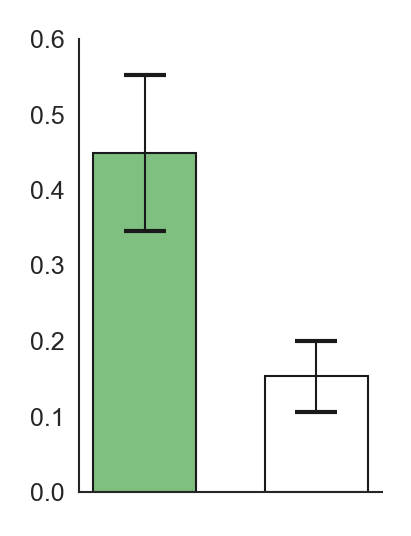

In [107]:
n=len(ratios)
left=range(n)
colors=["green","w"]
colors=[to_rgba(x,0.5) for x in colors]
fig=plt.figure(figsize=((1.3,2)))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)

ax.set_xticklabels([], rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,0.6)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## 2D plot

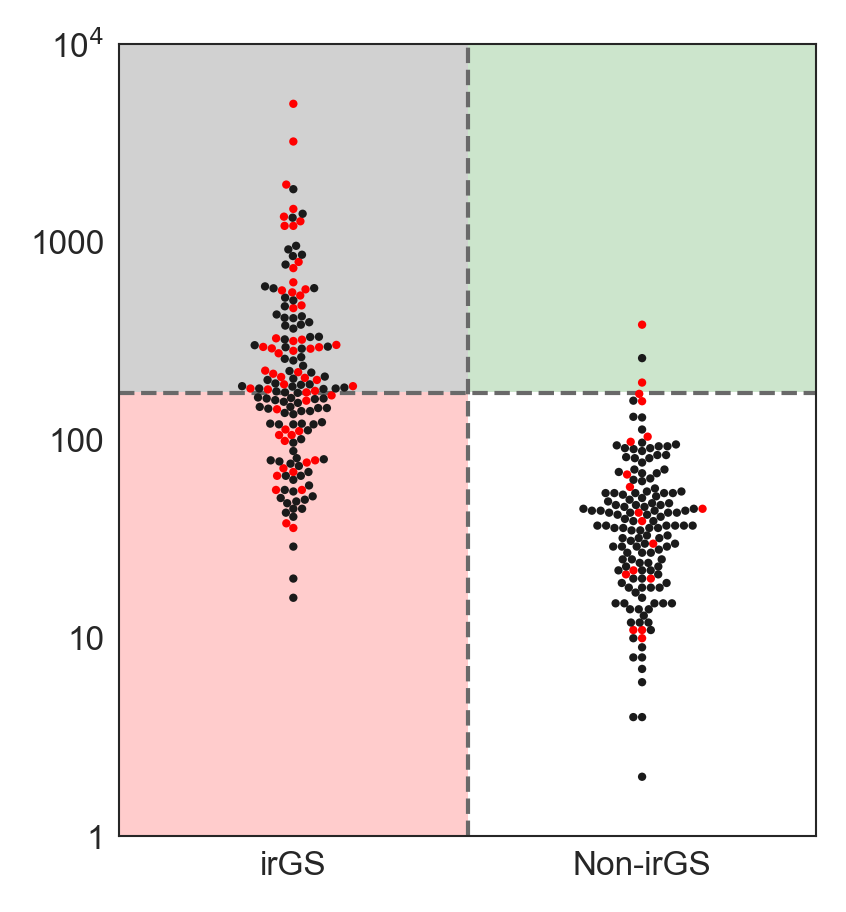

In [108]:
fig=plt.figure(figsize=(3,3.5))
ax=fig.add_subplot(111)
sns.swarmplot(x=cat1,y=value,data=df,
              s=2,ax=ax,hue=flag,hue_order=[0,1],
              palette=["k","red"],
             order=[1,0])
ax.set_ylabel("",fontsize=8)
ax.set_xlabel("")
ax.axvline(x=0.5,c="dimgrey",lw=1,ls="dashed")
ax.tick_params(labelsize=6)
ax.set_xticklabels(["irGS","Non-irGS"], rotation=0, fontsize=8)
ax.set_yticks([0,1,2,3,4])
ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8)
ax.legend([])

ax.axhline(y=np.log10(173),c="dimgrey",lw=1,ls="dashed")
p1=patches.Rectangle(xy=(-0.5,0),width=1,height=np.log10(cutoff1+1),ec="w",fc="red",alpha=0.2,
                 linewidth=0)
p2=patches.Rectangle(xy=(-0.5,np.log10(cutoff1+1)),width=1,height=4.2-np.log10(cutoff1+1),
                      ec="w",fc="k",alpha=0.2,
                     linewidth=0)
p3=patches.Rectangle(xy=(0.5,np.log10(cutoff1+1)),width=1,height=4.2-np.log10(cutoff1+1),
                      ec="w",fc="green",alpha=0.2,
                     linewidth=0)
ax.add_patch(p1)
ax.add_patch(p2)
ax.add_patch(p3)

In [109]:
class4=[]
for idx in df.index:
    if df.loc[idx,cat2]==1:
        if df.loc[idx,cat1]==1:
            class4.append("TMB high\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB high\nnon-irGS")
        else:
            class4.append("und")
    elif df.loc[idx,cat2]==0:
        if df.loc[idx,cat1]==1:
            class4.append("TMB low\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB low\nnon-irGS")
        else:
            class4.append("und")   
df["class4"]=class4

/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/gsp_env_p376/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [110]:
ct4=pd.crosstab(df["class4"],df[flag]).T
ct4=ct4.reindex(['TMB high\nirGS', 'TMB high\nnon-irGS', 'TMB low\nirGS','TMB low\nnon-irGS'],axis=1)
ct4

class4,TMB high\nirGS,TMB high\nnon-irGS,TMB low\nirGS,TMB low\nnon-irGS
Responder,,,,
0.0,48,1,54,134
1.0,38,2,18,16


In [111]:
ct=ct4.loc[:, ["TMB low\nirGS","TMB low\nnon-irGS"]]
res=stats.chi2_contingency(ct,correction=False)
display(ct)
print("Chi-square p= %.2e"%res[1])

class4,TMB low\nirGS,TMB low\nnon-irGS
Responder,,
0.0,54,134
1.0,18,16


Chi-square p= 5.50e-03


In [112]:
ratios=[]
errors=[]
labels=[]
for col in ct4.columns:
    count=ct4.loc[1,col]
    nobs=np.sum( ct4.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    
    ratios.append(ratio)   
    errors.append(np.array(cil-ratio, cih-ratio))
    labels.append(col)
    
    print(str(count)+"/"+str(nobs))

38/86
2/3
18/72
16/150


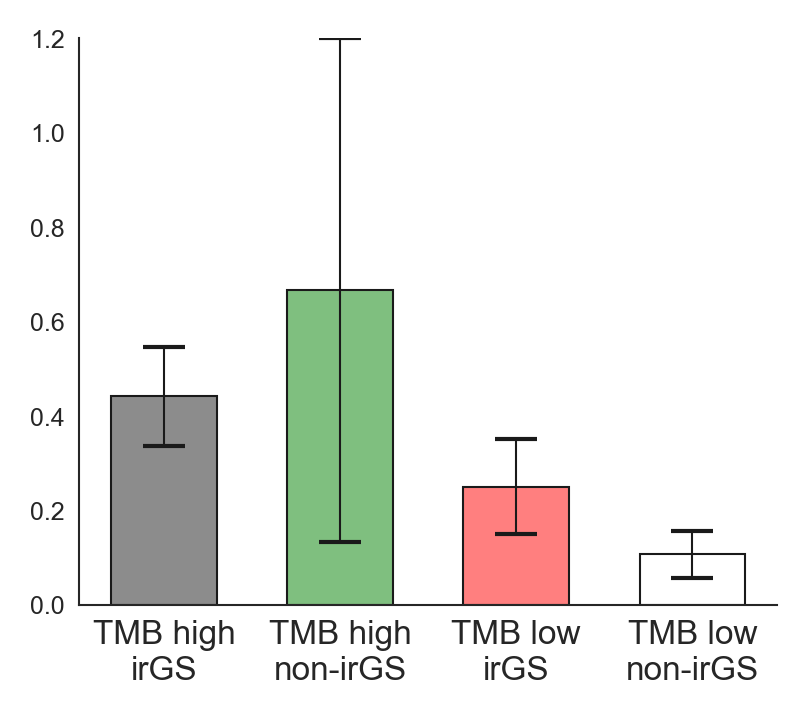

In [113]:
n=len(ratios)
left=range(n)
colors=["dimgrey","lightgrey"]*n
colors=["k","green","red","white"]
colors=[to_rgba(x, 0.5) for x in colors ]

fig=plt.figure(figsize=(3,2.5))
ax=fig.add_subplot(111)
ax.bar(x=left,height=ratios,yerr=errors,
       tick_label=labels,color=colors,capsize=5,width=0.6,edgecolor="k",lw=0.5)
ax.tick_params(labelsize=6)
ax.set_xticklabels(labels, rotation=0, fontsize=8)
ax.legend([])
ax.set_ylim(0,1.2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Logistic regression

In [114]:
Counter(df["irGS"])

Counter({1: 158, 0: 153})

In [115]:
Counter(df["TMB_high"])

Counter({1.0: 89, 0.0: 222})

In [116]:
Counter(df["CancerType"])

Counter({'Bladder': 17, 'Others': 95, 'Lung': 4, 'HNSCC': 106, 'Melanoma': 89})

In [117]:
df["CancerTypeR"]=df["CancerType"].replace(
        {'Melanoma':"1_Melanoma",
         'Lung': "4_Others",
         'Bladder': "3_Bladder",
         'HNSCC': "2_Head_neck",
         'Others': "4_Others"})

/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/gsp_env_p376/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [118]:
Counter(df["Sex"])

Counter({'Male': 194, 'Female': 117})

In [119]:
df["Sex_male"]=(df["Sex"]=="Male").astype(int)

/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/gsp_env_p376/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [120]:
Counter(df["Age_high"])

Counter({1.0: 151, 0.0: 160})

In [121]:
Y="Responder"
categories=["irGS","Missense_Mutation_log10","CancerTypeR","Sex_male","Age_high"]

In [122]:
# univariate
univ_integrated=pd.DataFrame()

for cat in categories:
    input_df=df.copy()
    formula = Y+" ~ "+cat
    family = sm.families.Binomial()
    model = smf.glm(formula=formula, data=input_df, family=family)
    res = model.fit()
    res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
    add=res_df.iloc[1:,:]

    univ_integrated=pd.concat([univ_integrated,add])

univ_integrated.columns=["Odds ratio","CI 5%","CI 95%", "P-value"]

res_df=univ_integrated
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","P-value"]],3) )

for i in res_df["P-value"]:
    print("{:.2e}".format(i))

,Odds ratio,95%CI,P-value
irGS,4.118,(2.28 - 7.43),0.000
Missense_Mutation_log10,4.379,(2.55 - 7.52),0.000
CancerTypeR[T.2_Head_neck],0.312,(0.16 - 0.59),0.000
CancerTypeR[T.3_Bladder],0.288,(0.08 - 1.07),0.063
CancerTypeR[T.4_Others],0.203,(0.10 - 0.42),0.000
Sex_male,1.581,(0.90 - 2.77),0.110
Age_high,0.812,(0.48 - 1.37),0.435


2.58e-06
8.99e-08
3.85e-04
6.34e-02
1.36e-05
1.10e-01
4.35e-01


In [123]:
# multivariate
categories=["irGS","Missense_Mutation_log10","CancerTypeR"]
input_df=df.copy()
res = smf.glm(formula = Y+" ~ "+"+".join(categories),
                  data = input_df,
                  family = sm.families.Binomial()).fit()

res_df=pd.concat( [ np.exp(res.params), np.exp(res.conf_int(alpha=0.05)),res.pvalues],axis=1)
res_df.columns=["Odds ratio","CI 5%","CI 95%", "p-value"]
res_df["95%CI"]=["({:.2f} - {:.2f})".format(x,y) for x,y in zip(res_df["CI 5%"],res_df["CI 95%"])  ]
display( np.round(res_df[["Odds ratio","95%CI","p-value"]],3) )

for i in res_df["p-value"]:
    print("{:.2g}".format(i))

,Odds ratio,95%CI,p-value
Intercept,0.064,(0.01 - 0.29),0.000
CancerTypeR[T.2_Head_neck],0.518,(0.26 - 1.04),0.066
CancerTypeR[T.3_Bladder],0.340,(0.09 - 1.31),0.118
CancerTypeR[T.4_Others],0.473,(0.20 - 1.09),0.079
irGS,1.746,(0.77 - 3.96),0.182
Missense_Mutation_log10,2.336,(1.12 - 4.85),0.023


0.00038
0.066
0.12
0.079
0.18
0.023


In [124]:
 df["CancerType details2"]=df["CancerType details"].replace({"BR_ER+HER-":"BR","BR_TNBC":"BR","HNSCC_Exp":"HNSCC"})

/Users/tshiro/.pyenv/versions/miniforge3-4.10/envs/gsp_env_p376/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [125]:
tmp=pd.crosstab(df["CancerType details2"],df["Tumor genomic subtype"]).loc[:,cluster_order2]
tmp["Total"]=np.sum(tmp,axis=1)
tmp.sort_values("Total",ascending=False)

Tumor genomic subtype,SMK,UVL,APB,MRD,POL,HRD,GNS,AGE,UND,Total
CancerType details2,,,,,,,,,,
HNSCC,13,2,35,0,0,14,0,36,6,106
Melanoma,0,72,0,0,0,10,0,4,3,89
Urothelial,1,0,14,0,0,0,0,2,0,17
BR,0,0,2,0,0,6,0,4,2,14
Gastric,0,0,0,1,0,1,0,8,0,10
SalivaryGland,0,0,1,0,0,7,0,2,0,10
ThyroidCancer,0,0,0,0,0,3,2,4,0,9
Analcanal_SCC,0,0,6,0,0,0,0,2,0,8
Mesothelioma,0,0,0,0,0,2,3,1,1,7


## Forest plot

In [126]:
ratios=[]
cils=[]
cihs=[]
labels=[]

In [127]:
input_df=df.copy()
cat='irGS'
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    
input_df=df.copy()
cat='TMB_high'
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    
input_df=df.copy()
cat='CancerTypeR'
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    
input_df=df.copy()
cat="Sex_male"
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )
    
input_df=df.copy()
cat="Age_high"
ct=pd.crosstab(input_df[Y],input_df[cat])
ct=ct.loc[[1,0],:]
for i,col in enumerate(ct.columns):
    print(col)
    count=ct.loc[1,col]
    nobs=np.sum( ct.loc[:,col])
    ratio=count/nobs
    cil,cih=proportion_confint(count,nobs,alpha=0.05)
    ratios.append(ratio)
    cils.append(cil)
    cihs.append(cih)
    labels.append(cat+'_'+str(col) )  


0
1
0.0
1.0
1_Melanoma
2_Head_neck
3_Bladder
4_Others
0
1
0.0
1.0


irGS_0
irGS_1
TMB_high_0.0
TMB_high_1.0
CancerTypeR_1_Melanoma
CancerTypeR_2_Head_neck
CancerTypeR_3_Bladder
CancerTypeR_4_Others
Sex_male_0
Sex_male_1
Age_high_0.0
Age_high_1.0


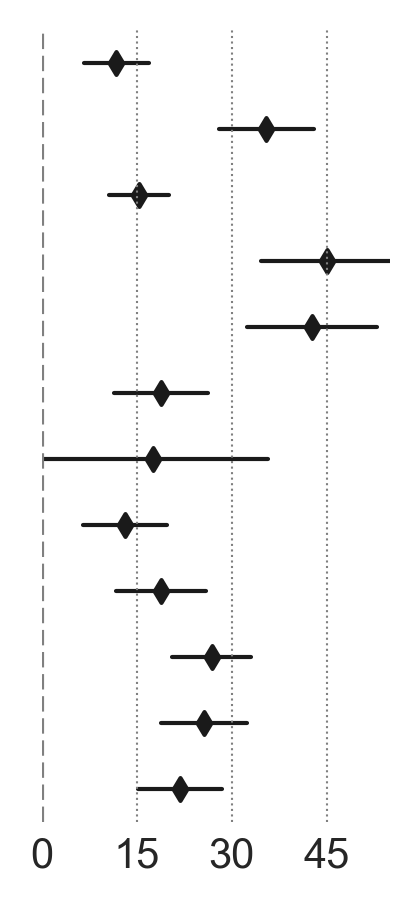

In [128]:
N=len(ratios)
fig=plt.figure(figsize=(1.5,3.5))
ax=fig.add_subplot(111)

for i in range(N):
    ax.scatter( ratios[i],i,c="k",s=15,marker='d' )
    ax.plot([cils[i],cihs[i]],[i,i],lw=1,c='k' )
    print(labels[i])


ax.axvline(x=0,ls='dashed',c='grey',lw=1)
ax.axvline(x=0.15,ls='dotted',c='grey')
ax.axvline(x=0.30,ls='dotted',c='grey')
ax.axvline(x=0.45,ls='dotted',c='grey')
ax.set_xlim(0,0.55)
ax.set_ylim(-0.5,N-0.5)   
ax.set_xticks([0,0.15,0.30,0.45])
ax.set_xticklabels(['0','15','30','45'],fontsize=10)
ax.set_yticks([])
ax.invert_yaxis()
ax.spines['top'   ].set_visible(False)# .set_color("w")
ax.spines['bottom'].set_visible(False)
ax.spines['left'  ].set_visible(False)
ax.spines['right' ].set_visible(False)

In [129]:
for i in ratios:
    print( '{:.1f}'.format(i*100) )

11.8
35.4
15.3
44.9
42.7
18.9
17.6
13.1
18.8
26.8
25.6
21.9


# Each dataset

In [130]:
df=df0.copy()

In [131]:
cat1="irGS"
cat2="TMB_high"

In [132]:
class4=[]
for idx in df.index:
    if df.loc[idx,cat2]==1:
        if df.loc[idx,cat1]==1:
            class4.append("TMB high\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB high\nnon-irGS")
        else:
            class4.append("und")
    elif df.loc[idx,cat2]==0:
        if df.loc[idx,cat1]==1:
            class4.append("TMB low\nirGS")
        elif df.loc[idx,cat1]==0:
            class4.append("TMB low\nnon-irGS")
        else:
            class4.append("und")   
df["class4"]=class4

In [133]:
refs=list(df["Reference"].unique())
refs

['Snyder, NEJM 2014',
 'Van Allen, Science 2015',
 'Hugo, Cell 2016',
 'Riaz, Cell 2017',
 'Roh, SciTraMed 2017',
 'Liu, NatMed 2019',
 'Rizvi, Science 2015',
 'Hellmann, CanCel 2018',
 'Anagnostou, NatCan 2020',
 'Snyder, PlosMed 2017',
 'Mariathasan, Nature 2018',
 'Miao, NatGen 2018',
 'Cristescu, Science 2018']

In [134]:
refs.insert(9,'')

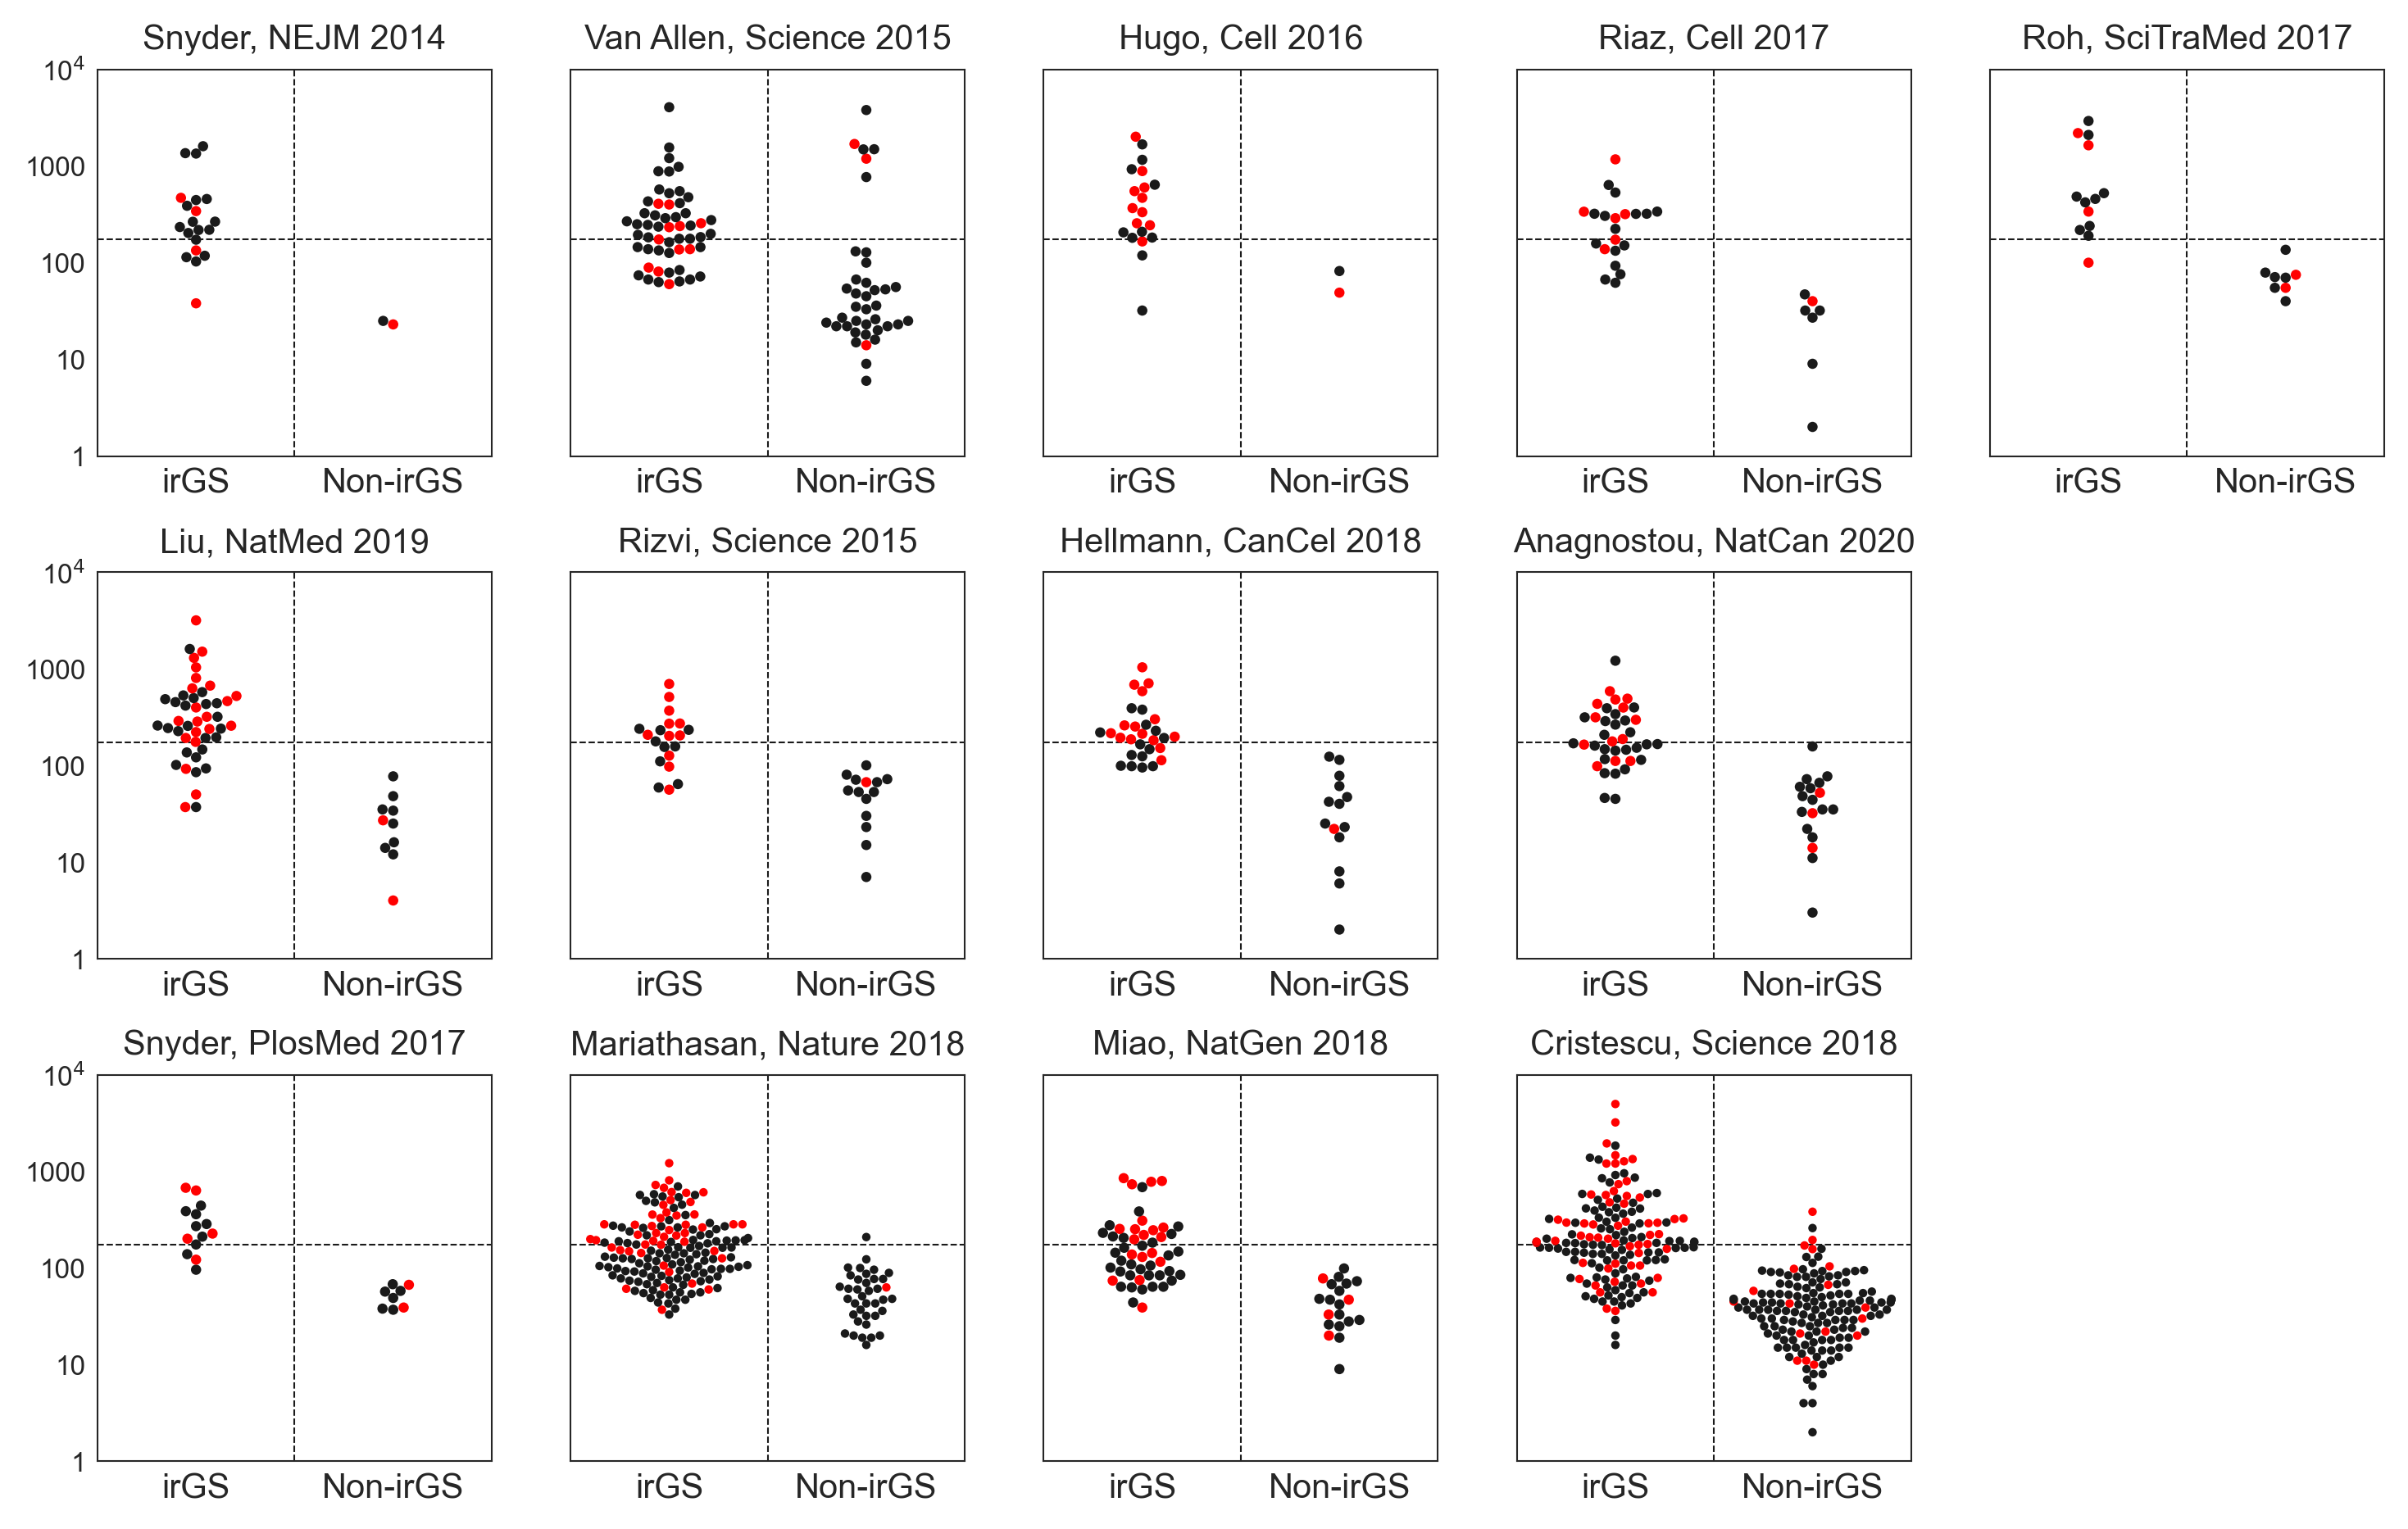

In [135]:
fig=plt.figure(figsize=(12,7.5))

for i,ref in enumerate(refs):
    if ref =="":
        continue
    input_df=df[df["Reference"]==ref]
    ax=fig.add_subplot(3,5,i+1)
    sns_df=input_df.copy()
    ax.axhline(y=np.log10(174),color="k",ls="dashed")
    ax.axvline(x=0.5,color="k",ls="dashed")
    ax.set_ylim(0,4)
    ax.tick_params(labelsize=6)
    s=3
    if len(input_df)>=100:
        s=2.5
    ax=sns.swarmplot(x="irGS",y="Missense_Mutation_log10",order=[1,0],data=sns_df,
                     hue="Responder",palette=["k","red"],s=s)
    ax.legend([])
    ax.set_title(ref,fontsize=10)
    ax.set_xlabel("")#'TMB log10',fontsize=8)
    ax.set_ylabel("")
    ax.set_xticklabels(["irGS","Non-irGS"],fontsize=10)
    
    if i in [0,5,10]:
        ax.set_yticks([0,1,2,3,4])
        ax.set_yticklabels(["1","10","100","1000","10$^{4}$"], rotation=0, fontsize=8) 
    else:
        ax.set_yticklabels([])

plt.subplots_adjust(hspace=0.3,wspace=0.2)
#plt.savefig(path_to_res+"SciTra2017_MEL_OR_2dplot.png",dpi=300,bbox_inches="tight")

In [136]:
refs.remove('')
refs

['Snyder, NEJM 2014',
 'Van Allen, Science 2015',
 'Hugo, Cell 2016',
 'Riaz, Cell 2017',
 'Roh, SciTraMed 2017',
 'Liu, NatMed 2019',
 'Rizvi, Science 2015',
 'Hellmann, CanCel 2018',
 'Anagnostou, NatCan 2020',
 'Snyder, PlosMed 2017',
 'Mariathasan, Nature 2018',
 'Miao, NatGen 2018',
 'Cristescu, Science 2018']

In [137]:
ct=pd.crosstab(df["Reference"],df["Tumor genomic subtype"])
ct.loc[refs,cluster_order2]

Tumor genomic subtype,SMK,UVL,APB,MRD,POL,HRD,GNS,AGE,UND
Reference,,,,,,,,,
"Snyder, NEJM 2014",0,20,0,0,0,1,0,1,0
"Van Allen, Science 2015",0,54,0,0,0,9,7,10,12
"Hugo, Cell 2016",0,20,0,0,0,1,0,0,1
"Riaz, Cell 2017",1,20,0,0,0,3,1,3,0
"Roh, SciTraMed 2017",1,11,0,0,0,4,0,4,1
"Liu, NatMed 2019",0,45,0,0,0,4,4,2,0
"Rizvi, Science 2015",17,0,2,0,0,6,1,5,3
"Hellmann, CanCel 2018",27,0,2,0,0,2,4,8,0
"Anagnostou, NatCan 2020",33,0,5,0,0,6,1,10,1
